# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [1]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [4]:
# How many samples do we have?
len(df)

3155

In [5]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [6]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


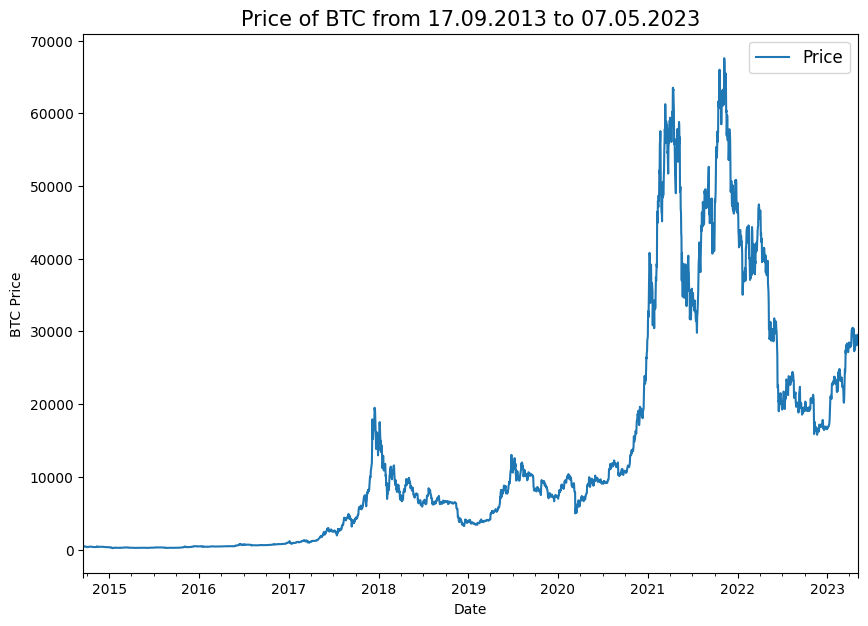

In [7]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

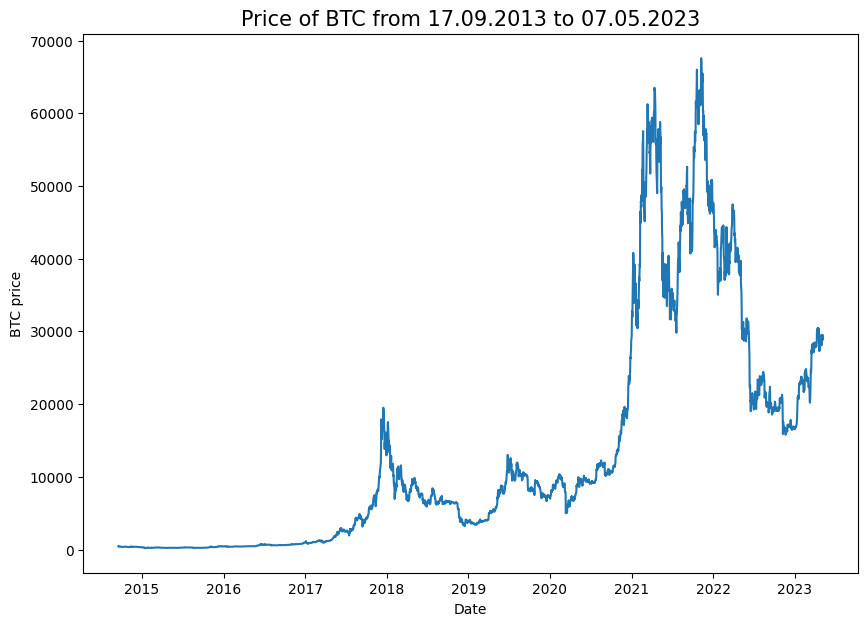

In [9]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

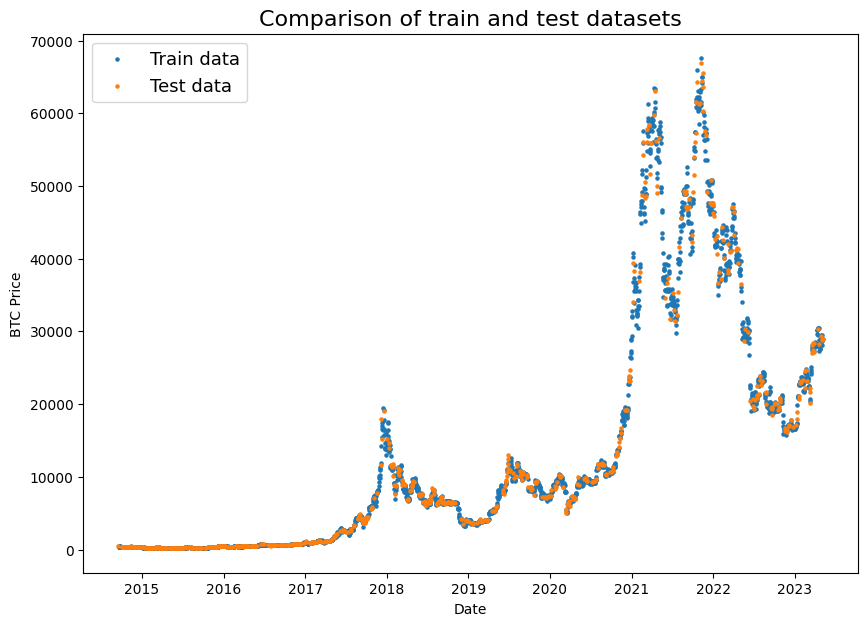

In [12]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [13]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

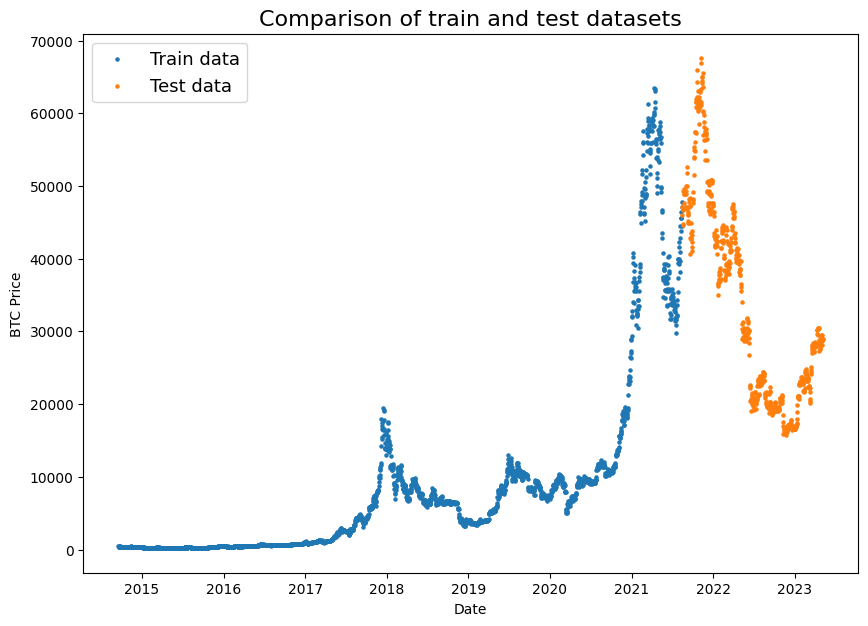

In [14]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

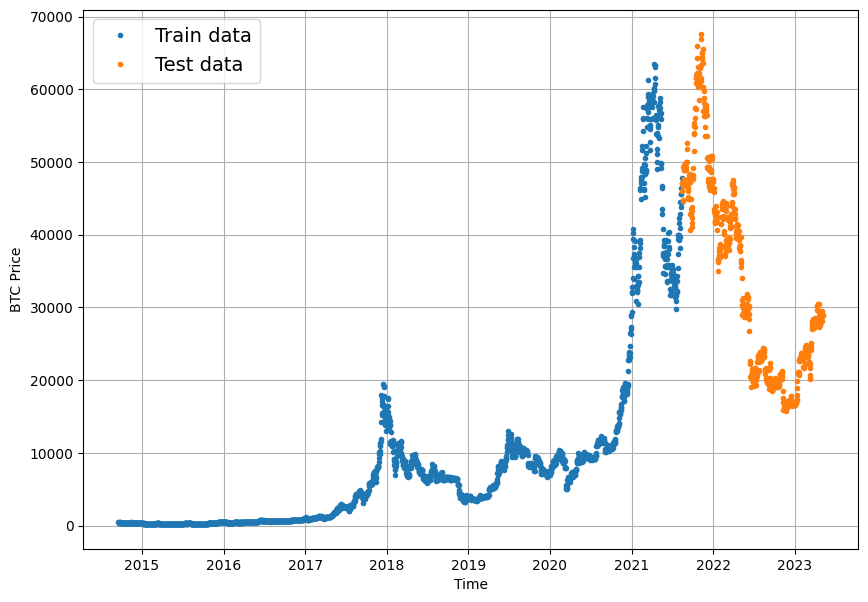

In [16]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [17]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

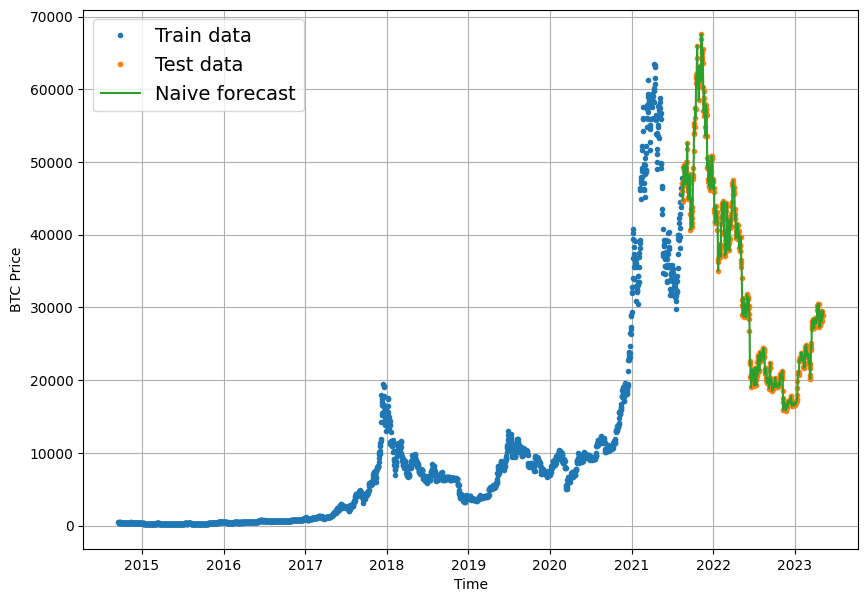

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

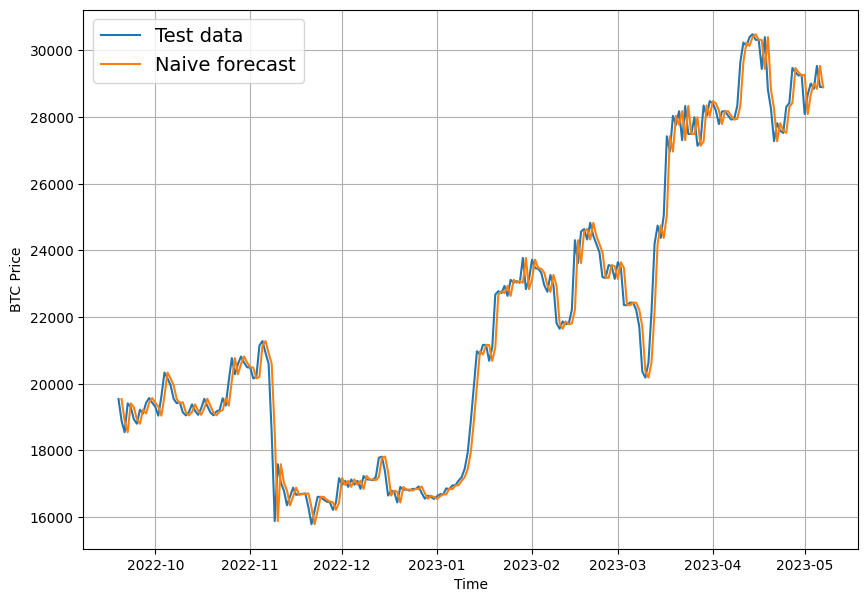

In [19]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [25]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [27]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [28]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [32]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [33]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [35]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [36]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [38]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [39]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
72/79 [==========================>...] - ETA: 0s - loss: 1307.7400 - mae: 1307.7400 - mse: 14813377.0000
Epoch 1: val_loss improved from inf to 1849.41272, saving model to model_experiments/model_1_dense


79/79 [==============================] - 10s 18ms/step - loss: 1257.0621 - mae: 1257.0621 - mse: 13755048.0000 - val_loss: 1849.4127 - val_mae: 1849.4127 - val_mse: 6448055.5000
Epoch 2/100
71/79 [=========================>....] - ETA: 0s - loss: 512.7641 - mae: 512.7641 - mse: 1490307.8750
Epoch 2: val_loss improved from 1849.41272 to 1327.18970, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 505.9855 - mae: 505.9855 - mse: 1426359.2500 - val_loss: 1327.1897 - val_mae: 1327.1897 - val_mse: 3658685.0000
Epoch 3/100
76/79 [===========================>..] - ETA: 0s - loss: 457.0783 - mae: 457.0783 - mse: 1145717.5000
Epoch 3: val_loss improved from 1327.18970 to 1214.32593, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 458.1756 - mae: 458.1756 - mse: 1148403.2500 - val_loss: 1214.3259 - val_mae: 1214.3259 - val_mse: 3081723.2500
Epoch 4/100
72/79 [==========================>...] - ETA: 0s - loss: 404.3986 - mae: 404.3986 - mse: 915367.4375
Epoch 4: val_loss did not improve from 1214.32593
79/79 [==============================] - 0s 4ms/step - loss: 414.7654 - mae: 414.7654 - mse: 959870.5625 - val_loss: 1284.2264 - val_mae: 1284.2264 - val_mse: 3309452.0000
Epoch 5/100
76/79 [===========================>..] - ETA: 0s - loss: 413.4103 - mae: 413.4103 - mse: 929637.8125
Epoch 5: val_loss improved from 1214.32593 to 1046.97375, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 409.2882 - mae: 409.2882 - mse: 917987.4375 - val_loss: 1046.9738 - val_mae: 1046.9738 - val_mse: 2320241.7500
Epoch 6/100
77/79 [============================>.] - ETA: 0s - loss: 385.8116 - mae: 385.8116 - mse: 815411.2500
Epoch 6: val_loss did not improve from 1046.97375
79/79 [==============================] - 0s 3ms/step - loss: 386.2280 - mae: 386.2280 - mse: 810961.1875 - val_loss: 1096.7588 - val_mae: 1096.7588 - val_mse: 2524582.5000
Epoch 7/100
72/79 [==========================>...] - ETA: 0s - loss: 350.8675 - mae: 350.8675 - mse: 707268.0000
Epoch 7: val_loss did not improve from 1046.97375
79/79 [==============================] - 0s 4ms/step - loss: 348.8395 - mae: 348.8395 - mse: 694887.0625 - val_loss: 1416.8684 - val_mae: 1416.8684 - val_mse: 3740863.7500
Epoch 8/100
70/79 [=========================>....] - ETA: 0s - loss: 349.0718 - mae: 349.0718 - mse: 654115.6250
Epoch 8: val_loss did not improve from 1046.9

79/79 [==============================] - 1s 9ms/step - loss: 360.0788 - mae: 360.0788 - mse: 707960.8125 - val_loss: 986.9008 - val_mae: 986.9008 - val_mse: 2025989.5000
Epoch 10/100
76/79 [===========================>..] - ETA: 0s - loss: 342.3774 - mae: 342.3774 - mse: 653083.5000
Epoch 10: val_loss improved from 986.90082 to 972.82562, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 342.2386 - mae: 342.2386 - mse: 645444.0625 - val_loss: 972.8256 - val_mae: 972.8256 - val_mse: 2032371.7500
Epoch 11/100
77/79 [============================>.] - ETA: 0s - loss: 320.7710 - mae: 320.7710 - mse: 578285.3750
Epoch 11: val_loss did not improve from 972.82562
79/79 [==============================] - 0s 4ms/step - loss: 318.3499 - mae: 318.3499 - mse: 570038.1250 - val_loss: 1069.6216 - val_mae: 1069.6216 - val_mse: 2365769.2500
Epoch 12/100
72/79 [==========================>...] - ETA: 0s - loss: 331.4420 - mae: 331.4420 - mse: 601825.5625
Epoch 12: val_loss did not improve from 972.82562
79/79 [==============================] - 0s 4ms/step - loss: 330.1712 - mae: 330.1712 - mse: 616870.5000 - val_loss: 1277.1208 - val_mae: 1277.1208 - val_mse: 3092648.5000
Epoch 13/100
76/79 [===========================>..] - ETA: 0s - loss: 313.3231 - mae: 313.3231 - mse: 563430.3125
Epoch 13: val_loss improved from 972.82562 t

79/79 [==============================] - 1s 9ms/step - loss: 315.4822 - mae: 315.4822 - mse: 580280.1250 - val_loss: 916.3599 - val_mae: 916.3599 - val_mse: 1799714.3750
Epoch 14/100
76/79 [===========================>..] - ETA: 0s - loss: 324.4420 - mae: 324.4420 - mse: 606016.6250
Epoch 14: val_loss did not improve from 916.35992
79/79 [==============================] - 0s 4ms/step - loss: 327.1465 - mae: 327.1465 - mse: 608641.3125 - val_loss: 1431.1267 - val_mae: 1431.1267 - val_mse: 3649059.7500
Epoch 15/100
77/79 [============================>.] - ETA: 0s - loss: 310.8524 - mae: 310.8524 - mse: 558351.5625
Epoch 15: val_loss did not improve from 916.35992
79/79 [==============================] - 0s 3ms/step - loss: 307.6095 - mae: 307.6095 - mse: 549120.0000 - val_loss: 921.9935 - val_mae: 921.9935 - val_mse: 1787705.5000
Epoch 16/100
77/79 [============================>.] - ETA: 0s - loss: 310.8428 - mae: 310.8428 - mse: 545347.8750
Epoch 16: val_loss did not improve from 916.35

79/79 [==============================] - 1s 9ms/step - loss: 297.9159 - mae: 297.9159 - mse: 538891.7500 - val_loss: 883.3976 - val_mae: 883.3976 - val_mse: 1678359.6250
Epoch 19/100
72/79 [==========================>...] - ETA: 0s - loss: 306.2809 - mae: 306.2809 - mse: 554106.4375
Epoch 19: val_loss did not improve from 883.39764
79/79 [==============================] - 0s 4ms/step - loss: 305.8453 - mae: 305.8453 - mse: 542658.3750 - val_loss: 1137.0156 - val_mae: 1137.0156 - val_mse: 2513542.0000
Epoch 20/100
75/79 [===========================>..] - ETA: 0s - loss: 330.9856 - mae: 330.9856 - mse: 634615.8125
Epoch 20: val_loss did not improve from 883.39764
79/79 [==============================] - 0s 6ms/step - loss: 326.8544 - mae: 326.8544 - mse: 616796.3750 - val_loss: 1029.3533 - val_mae: 1029.3533 - val_mse: 2161587.0000
Epoch 21/100
68/79 [========================>.....] - ETA: 0s - loss: 298.6115 - mae: 298.6115 - mse: 536509.1875
Epoch 21: val_loss did not improve from 883.

79/79 [==============================] - 1s 13ms/step - loss: 315.7320 - mae: 315.7320 - mse: 535215.9375 - val_loss: 882.8522 - val_mae: 882.8522 - val_mse: 1714315.7500
Epoch 26/100
63/79 [======================>.......] - ETA: 0s - loss: 273.0543 - mae: 273.0543 - mse: 472199.3125
Epoch 26: val_loss did not improve from 882.85217
79/79 [==============================] - 0s 5ms/step - loss: 288.3946 - mae: 288.3946 - mse: 504333.1562 - val_loss: 1346.3596 - val_mae: 1346.3596 - val_mse: 3209656.7500
Epoch 27/100
73/79 [==========================>...] - ETA: 0s - loss: 279.9361 - mae: 279.9361 - mse: 457517.3750
Epoch 27: val_loss did not improve from 882.85217
79/79 [==============================] - 0s 4ms/step - loss: 289.2236 - mae: 289.2236 - mse: 490835.8750 - val_loss: 916.7520 - val_mae: 916.7520 - val_mse: 1797808.3750
Epoch 28/100
71/79 [=========================>....] - ETA: 0s - loss: 307.8873 - mae: 307.8873 - mse: 557118.8750
Epoch 28: val_loss did not improve from 882.8

79/79 [==============================] - 1s 13ms/step - loss: 290.3480 - mae: 290.3480 - mse: 507656.9375 - val_loss: 807.3517 - val_mae: 807.3517 - val_mse: 1504872.1250
Epoch 30/100
74/79 [===========================>..] - ETA: 0s - loss: 278.7441 - mae: 278.7441 - mse: 479910.7500
Epoch 30: val_loss did not improve from 807.35168
79/79 [==============================] - 0s 4ms/step - loss: 279.0248 - mae: 279.0248 - mse: 474454.1250 - val_loss: 921.6253 - val_mae: 921.6253 - val_mse: 1801340.5000
Epoch 31/100
77/79 [============================>.] - ETA: 0s - loss: 280.0860 - mae: 280.0860 - mse: 457492.1562
Epoch 31: val_loss improved from 807.35168 to 801.44189, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 279.7186 - mae: 279.7186 - mse: 457179.0938 - val_loss: 801.4419 - val_mae: 801.4419 - val_mse: 1485496.8750
Epoch 32/100
60/79 [=====================>........] - ETA: 0s - loss: 271.7624 - mae: 271.7624 - mse: 492082.1875
Epoch 32: val_loss improved from 801.44189 to 797.80548, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 271.9996 - mae: 271.9996 - mse: 457946.7500 - val_loss: 797.8055 - val_mae: 797.8055 - val_mse: 1478889.7500
Epoch 33/100
65/79 [=======================>......] - ETA: 0s - loss: 277.2878 - mae: 277.2878 - mse: 470860.1875
Epoch 33: val_loss did not improve from 797.80548
79/79 [==============================] - 0s 4ms/step - loss: 284.9565 - mae: 284.9565 - mse: 491449.6562 - val_loss: 953.3320 - val_mae: 953.3320 - val_mse: 1807186.2500
Epoch 34/100
75/79 [===========================>..] - ETA: 0s - loss: 333.7746 - mae: 333.7746 - mse: 600900.5000
Epoch 34: val_loss did not improve from 797.80548
79/79 [==============================] - 0s 4ms/step - loss: 334.7228 - mae: 334.7228 - mse: 607830.0625 - val_loss: 1796.0653 - val_mae: 1796.0653 - val_mse: 4795321.5000
Epoch 35/100
75/79 [===========================>..] - ETA: 0s - loss: 291.2210 - mae: 291.2210 - mse: 529060.1875
Epoch 35: val_loss did not improve from 797.80

79/79 [==============================] - 1s 9ms/step - loss: 316.1780 - mae: 316.1780 - mse: 560639.3125 - val_loss: 793.0137 - val_mae: 793.0137 - val_mse: 1467334.5000
Epoch 38/100
73/79 [==========================>...] - ETA: 0s - loss: 272.0424 - mae: 272.0424 - mse: 450753.3750
Epoch 38: val_loss did not improve from 793.01373
79/79 [==============================] - 0s 4ms/step - loss: 283.8343 - mae: 283.8343 - mse: 493128.9375 - val_loss: 845.7232 - val_mae: 845.7232 - val_mse: 1596404.1250
Epoch 39/100
78/79 [============================>.] - ETA: 0s - loss: 285.6159 - mae: 285.6159 - mse: 489891.3750
Epoch 39: val_loss did not improve from 793.01373
79/79 [==============================] - 0s 4ms/step - loss: 285.3362 - mae: 285.3362 - mse: 486616.9688 - val_loss: 981.0986 - val_mae: 981.0986 - val_mse: 1866737.7500
Epoch 40/100
77/79 [============================>.] - ETA: 0s - loss: 291.2951 - mae: 291.2951 - mse: 498426.6875
Epoch 40: val_loss improved from 793.01373 to 79

79/79 [==============================] - 1s 9ms/step - loss: 292.0088 - mae: 292.0088 - mse: 498262.3125 - val_loss: 790.4211 - val_mae: 790.4211 - val_mse: 1443446.2500
Epoch 41/100
78/79 [============================>.] - ETA: 0s - loss: 273.7508 - mae: 273.7508 - mse: 468826.4688
Epoch 41: val_loss did not improve from 790.42108
79/79 [==============================] - 0s 4ms/step - loss: 273.6481 - mae: 273.6481 - mse: 468519.0938 - val_loss: 791.5831 - val_mae: 791.5831 - val_mse: 1442611.0000
Epoch 42/100
78/79 [============================>.] - ETA: 0s - loss: 271.8392 - mae: 271.8392 - mse: 454166.9688
Epoch 42: val_loss did not improve from 790.42108
79/79 [==============================] - 0s 4ms/step - loss: 273.6925 - mae: 273.6925 - mse: 461709.5312 - val_loss: 799.4599 - val_mae: 799.4599 - val_mse: 1482732.2500
Epoch 43/100
71/79 [=========================>....] - ETA: 0s - loss: 284.9829 - mae: 284.9829 - mse: 488980.4375
Epoch 43: val_loss did not improve from 790.4210

79/79 [==============================] - 1s 13ms/step - loss: 283.4363 - mae: 283.4363 - mse: 497955.6875 - val_loss: 790.3073 - val_mae: 790.3073 - val_mse: 1457623.5000
Epoch 55/100
76/79 [===========================>..] - ETA: 0s - loss: 290.1116 - mae: 290.1116 - mse: 497058.6875
Epoch 55: val_loss did not improve from 790.30731
79/79 [==============================] - 0s 5ms/step - loss: 289.4793 - mae: 289.4793 - mse: 490103.6250 - val_loss: 1109.8134 - val_mae: 1109.8134 - val_mse: 2333094.2500
Epoch 56/100
77/79 [============================>.] - ETA: 0s - loss: 272.8518 - mae: 272.8518 - mse: 449515.7500
Epoch 56: val_loss did not improve from 790.30731
79/79 [==============================] - 0s 5ms/step - loss: 275.1083 - mae: 275.1083 - mse: 459774.5625 - val_loss: 790.9806 - val_mae: 790.9806 - val_mse: 1436625.2500
Epoch 57/100
77/79 [============================>.] - ETA: 0s - loss: 286.3757 - mae: 286.3757 - mse: 498555.9062
Epoch 57: val_loss did not improve from 790.3

79/79 [==============================] - 1s 9ms/step - loss: 274.1104 - mae: 274.1104 - mse: 463790.8750 - val_loss: 783.9874 - val_mae: 783.9874 - val_mse: 1439224.2500
Epoch 62/100
75/79 [===========================>..] - ETA: 0s - loss: 278.5448 - mae: 278.5448 - mse: 485887.7812
Epoch 62: val_loss did not improve from 783.98737
79/79 [==============================] - 0s 4ms/step - loss: 279.9367 - mae: 279.9367 - mse: 482532.3438 - val_loss: 786.9021 - val_mae: 786.9021 - val_mse: 1447776.2500
Epoch 63/100
77/79 [============================>.] - ETA: 0s - loss: 264.0114 - mae: 264.0114 - mse: 433717.2188
Epoch 63: val_loss did not improve from 783.98737
79/79 [==============================] - 0s 4ms/step - loss: 270.4352 - mae: 270.4352 - mse: 453512.3438 - val_loss: 969.9943 - val_mae: 969.9943 - val_mse: 1915714.6250
Epoch 64/100
75/79 [===========================>..] - ETA: 0s - loss: 272.9889 - mae: 272.9889 - mse: 470860.0938
Epoch 64: val_loss improved from 783.98737 to 78

79/79 [==============================] - 1s 9ms/step - loss: 274.3429 - mae: 274.3429 - mse: 484360.0938 - val_loss: 781.4315 - val_mae: 781.4315 - val_mse: 1432112.5000
Epoch 65/100
77/79 [============================>.] - ETA: 0s - loss: 270.9351 - mae: 270.9351 - mse: 436165.3125
Epoch 65: val_loss did not improve from 781.43146
79/79 [==============================] - 0s 4ms/step - loss: 273.9729 - mae: 273.9729 - mse: 462667.6875 - val_loss: 820.3288 - val_mae: 820.3288 - val_mse: 1517995.1250
Epoch 66/100
73/79 [==========================>...] - ETA: 0s - loss: 272.1867 - mae: 272.1867 - mse: 461758.7500
Epoch 66: val_loss did not improve from 781.43146
79/79 [==============================] - 0s 4ms/step - loss: 269.3253 - mae: 269.3253 - mse: 452019.5938 - val_loss: 787.8801 - val_mae: 787.8801 - val_mse: 1428616.6250
Epoch 67/100
73/79 [==========================>...] - ETA: 0s - loss: 290.8061 - mae: 290.8061 - mse: 481343.9375
Epoch 67: val_loss did not improve from 781.4314

79/79 [==============================] - 1s 10ms/step - loss: 323.4831 - mae: 323.4831 - mse: 582408.7500 - val_loss: 778.3483 - val_mae: 778.3483 - val_mse: 1429629.5000
Epoch 69/100
73/79 [==========================>...] - ETA: 0s - loss: 280.8907 - mae: 280.8907 - mse: 477035.3438
Epoch 69: val_loss did not improve from 778.34833
79/79 [==============================] - 0s 4ms/step - loss: 278.9796 - mae: 278.9796 - mse: 472506.7188 - val_loss: 856.2779 - val_mae: 856.2779 - val_mse: 1613494.5000
Epoch 70/100
73/79 [==========================>...] - ETA: 0s - loss: 271.3650 - mae: 271.3650 - mse: 445964.9375
Epoch 70: val_loss did not improve from 778.34833
79/79 [==============================] - 0s 4ms/step - loss: 269.6635 - mae: 269.6635 - mse: 440435.6875 - val_loss: 828.1983 - val_mae: 828.1983 - val_mse: 1501939.3750
Epoch 71/100
73/79 [==========================>...] - ETA: 0s - loss: 280.2102 - mae: 280.2102 - mse: 482217.2500
Epoch 71: val_loss did not improve from 778.348

79/79 [==============================] - 1s 10ms/step - loss: 289.1326 - mae: 289.1326 - mse: 472177.2500 - val_loss: 776.6027 - val_mae: 776.6027 - val_mse: 1416948.0000
Epoch 84/100
74/79 [===========================>..] - ETA: 0s - loss: 282.9889 - mae: 282.9889 - mse: 464991.5625
Epoch 84: val_loss did not improve from 776.60266
79/79 [==============================] - 0s 4ms/step - loss: 285.7723 - mae: 285.7723 - mse: 474204.8750 - val_loss: 778.3370 - val_mae: 778.3370 - val_mse: 1416866.1250
Epoch 85/100
79/79 [==============================] - ETA: 0s - loss: 274.3381 - mae: 274.3381 - mse: 443485.0625
Epoch 85: val_loss did not improve from 776.60266
79/79 [==============================] - 0s 5ms/step - loss: 274.3381 - mae: 274.3381 - mse: 443485.0625 - val_loss: 815.2868 - val_mae: 815.2868 - val_mse: 1508639.5000
Epoch 86/100
68/79 [========================>.....] - ETA: 0s - loss: 295.2220 - mae: 295.2220 - mse: 519252.1875
Epoch 86: val_loss did not improve from 776.602

79/79 [==============================] - 1s 10ms/step - loss: 273.2386 - mae: 273.2386 - mse: 467582.3125 - val_loss: 775.3892 - val_mae: 775.3892 - val_mse: 1413157.1250
Epoch 94/100
78/79 [============================>.] - ETA: 0s - loss: 282.2061 - mae: 282.2061 - mse: 477616.8125
Epoch 94: val_loss did not improve from 775.38916
79/79 [==============================] - 0s 4ms/step - loss: 281.4264 - mae: 281.4264 - mse: 477149.1875 - val_loss: 816.0691 - val_mae: 816.0691 - val_mse: 1511389.8750
Epoch 95/100
79/79 [==============================] - ETA: 0s - loss: 275.5596 - mae: 275.5596 - mse: 480147.8125
Epoch 95: val_loss did not improve from 775.38916
79/79 [==============================] - 0s 4ms/step - loss: 275.5596 - mae: 275.5596 - mse: 480147.8125 - val_loss: 1020.6716 - val_mae: 1020.6716 - val_mse: 2055907.3750
Epoch 96/100
77/79 [============================>.] - ETA: 0s - loss: 282.7093 - mae: 282.7093 - mse: 486744.6875
Epoch 96: val_loss did not improve from 775.3

In [42]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 869.1927 - mae: 869.1927 - mse: 1583644.5000


[869.1926879882812, 869.1926879882812, 1583644.5]

In [43]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 775.3892 - mae: 775.3892 - mse: 1413157.1250


[775.38916015625, 775.38916015625, 1413157.125]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [45]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47015.89 , 46180.965, 44703.867, 44721.254, 46392.9  , 49081.46 ,
        49075.844, 49373.625, 49649.16 , 47925.91 ], dtype=float32)>,
 630)

In [46]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [47]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

In [48]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

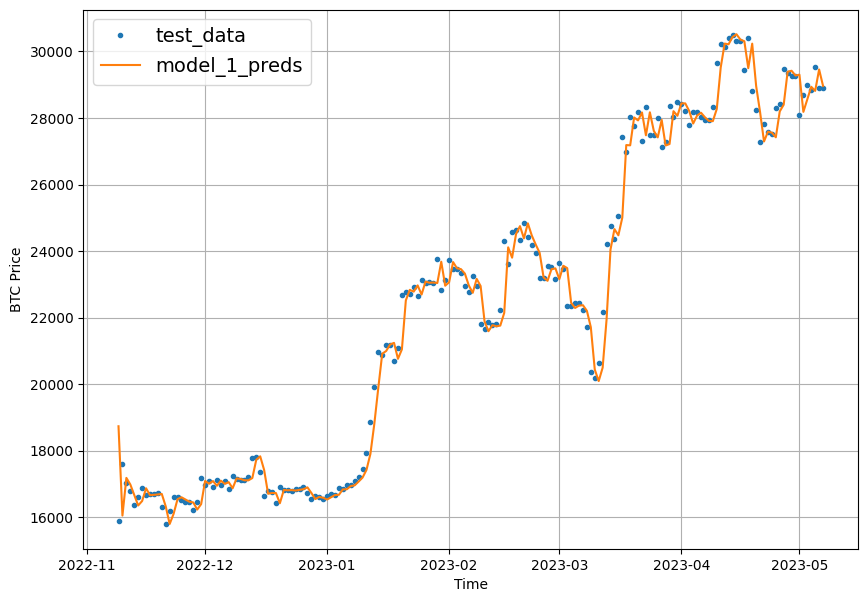

In [49]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [53]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [54]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 6672.05078, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 6672.05078 to 2367.12329, saving model to model_experiments/model_2_dense



Epoch 3: val_loss improved from 2367.12329 to 2145.16528, saving model to model_experiments/model_2_dense



Epoch 4: val_loss improved from 2145.16528 to 1994.70459, saving model to model_experiments/model_2_dense



Epoch 5: val_loss did not improve from 1994.70459

Epoch 6: val_loss improved from 1994.70459 to 1695.52795, saving model to model_experiments/model_2_dense



Epoch 7: val_loss did not improve from 1695.52795

Epoch 8: val_loss did not improve from 1695.52795

Epoch 9: val_loss did not improve from 1695.52795

Epoch 10: val_loss improved from 1695.52795 to 1536.44788, saving model to model_experiments/model_2_dense



Epoch 11: val_loss did not improve from 1536.44788

Epoch 12: val_loss improved from 1536.44788 to 1456.14624, saving model to model_experiments/model_2_dense



Epoch 13: val_loss did not improve from 1456.14624

Epoch 14: val_loss did not improve from 1456.14624

Epoch 15: val_loss did not improve from 1456.14624

Epoch 16: val_loss improved from 1456.14624 to 1281.74573, saving model to model_experiments/model_2_dense



Epoch 17: val_loss improved from 1281.74573 to 1258.63818, saving model to model_experiments/model_2_dense



Epoch 18: val_loss did not improve from 1258.63818

Epoch 19: val_loss improved from 1258.63818 to 1217.93591, saving model to model_experiments/model_2_dense



Epoch 20: val_loss did not improve from 1217.93591

Epoch 21: val_loss improved from 1217.93591 to 1181.69824, saving model to model_experiments/model_2_dense



Epoch 22: val_loss did not improve from 1181.69824

Epoch 23: val_loss did not improve from 1181.69824

Epoch 24: val_loss improved from 1181.69824 to 1154.38306, saving model to model_experiments/model_2_dense



Epoch 25: val_loss did not improve from 1154.38306

Epoch 26: val_loss did not improve from 1154.38306

Epoch 27: val_loss did not improve from 1154.38306

Epoch 28: val_loss improved from 1154.38306 to 1103.16614, saving model to model_experiments/model_2_dense



Epoch 29: val_loss did not improve from 1103.16614

Epoch 30: val_loss did not improve from 1103.16614

Epoch 31: val_loss did not improve from 1103.16614

Epoch 32: val_loss did not improve from 1103.16614

Epoch 33: val_loss did not improve from 1103.16614

Epoch 34: val_loss improved from 1103.16614 to 1090.08948, saving model to model_experiments/model_2_dense



Epoch 35: val_loss improved from 1090.08948 to 1081.58252, saving model to model_experiments/model_2_dense



Epoch 36: val_loss improved from 1081.58252 to 1047.57422, saving model to model_experiments/model_2_dense



Epoch 37: val_loss did not improve from 1047.57422

Epoch 38: val_loss did not improve from 1047.57422

Epoch 39: val_loss did not improve from 1047.57422

Epoch 40: val_loss improved from 1047.57422 to 1011.58362, saving model to model_experiments/model_2_dense



Epoch 41: val_loss did not improve from 1011.58362

Epoch 42: val_loss did not improve from 1011.58362

Epoch 43: val_loss did not improve from 1011.58362

Epoch 44: val_loss did not improve from 1011.58362

Epoch 45: val_loss did not improve from 1011.58362

Epoch 46: val_loss did not improve from 1011.58362

Epoch 47: val_loss did not improve from 1011.58362

Epoch 48: val_loss did not improve from 1011.58362

Epoch 49: val_loss did not improve from 1011.58362

Epoch 50: val_loss did not improve from 1011.58362

Epoch 51: val_loss did not improve from 1011.58362

Epoch 52: val_loss improved from 1011.58362 to 948.26941, saving model to model_experiments/model_2_dense



Epoch 53: val_loss did not improve from 948.26941

Epoch 54: val_loss did not improve from 948.26941

Epoch 55: val_loss did not improve from 948.26941

Epoch 56: val_loss improved from 948.26941 to 938.11121, saving model to model_experiments/model_2_dense



Epoch 57: val_loss did not improve from 938.11121

Epoch 58: val_loss improved from 938.11121 to 932.61401, saving model to model_experiments/model_2_dense



Epoch 59: val_loss did not improve from 932.61401

Epoch 60: val_loss did not improve from 932.61401

Epoch 61: val_loss did not improve from 932.61401

Epoch 62: val_loss did not improve from 932.61401

Epoch 63: val_loss did not improve from 932.61401

Epoch 64: val_loss did not improve from 932.61401

Epoch 65: val_loss did not improve from 932.61401

Epoch 66: val_loss improved from 932.61401 to 920.05450, saving model to model_experiments/model_2_dense



Epoch 67: val_loss did not improve from 920.05450

Epoch 68: val_loss did not improve from 920.05450

Epoch 69: val_loss did not improve from 920.05450

Epoch 70: val_loss did not improve from 920.05450

Epoch 71: val_loss did not improve from 920.05450

Epoch 72: val_loss improved from 920.05450 to 919.12561, saving model to model_experiments/model_2_dense



Epoch 73: val_loss did not improve from 919.12561

Epoch 74: val_loss did not improve from 919.12561

Epoch 75: val_loss did not improve from 919.12561

Epoch 76: val_loss improved from 919.12561 to 902.45428, saving model to model_experiments/model_2_dense



Epoch 77: val_loss did not improve from 902.45428

Epoch 78: val_loss did not improve from 902.45428

Epoch 79: val_loss did not improve from 902.45428

Epoch 80: val_loss did not improve from 902.45428

Epoch 81: val_loss did not improve from 902.45428

Epoch 82: val_loss did not improve from 902.45428

Epoch 83: val_loss did not improve from 902.45428

Epoch 84: val_loss improved from 902.45428 to 901.29272, saving model to model_experiments/model_2_dense



Epoch 85: val_loss improved from 901.29272 to 891.05762, saving model to model_experiments/model_2_dense



Epoch 86: val_loss did not improve from 891.05762

Epoch 87: val_loss improved from 891.05762 to 885.64478, saving model to model_experiments/model_2_dense



Epoch 88: val_loss did not improve from 885.64478

Epoch 89: val_loss did not improve from 885.64478

Epoch 90: val_loss did not improve from 885.64478

Epoch 91: val_loss did not improve from 885.64478

Epoch 92: val_loss did not improve from 885.64478

Epoch 93: val_loss did not improve from 885.64478

Epoch 94: val_loss did not improve from 885.64478

Epoch 95: val_loss did not improve from 885.64478

Epoch 96: val_loss did not improve from 885.64478

Epoch 97: val_loss did not improve from 885.64478

Epoch 98: val_loss improved from 885.64478 to 880.65070, saving model to model_experiments/model_2_dense



Epoch 99: val_loss did not improve from 880.65070

Epoch 100: val_loss did not improve from 880.65070


In [55]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1472.7615 - mse: 3535429.2500 - mae: 1472.7615


[1472.761474609375, 3535429.25, 1472.761474609375]

In [56]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 880.6508 - mse: 1684930.5000 - mae: 880.6508


[880.6508178710938, 1684930.5, 880.6508178710938]

In [57]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 2ms/step


In [58]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 880.651,
 'mse': 1684930.4,
 'rmse': 1298.0487,
 'mape': 2.625605,
 'mase': 1.1537279}

In [59]:
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

In [60]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

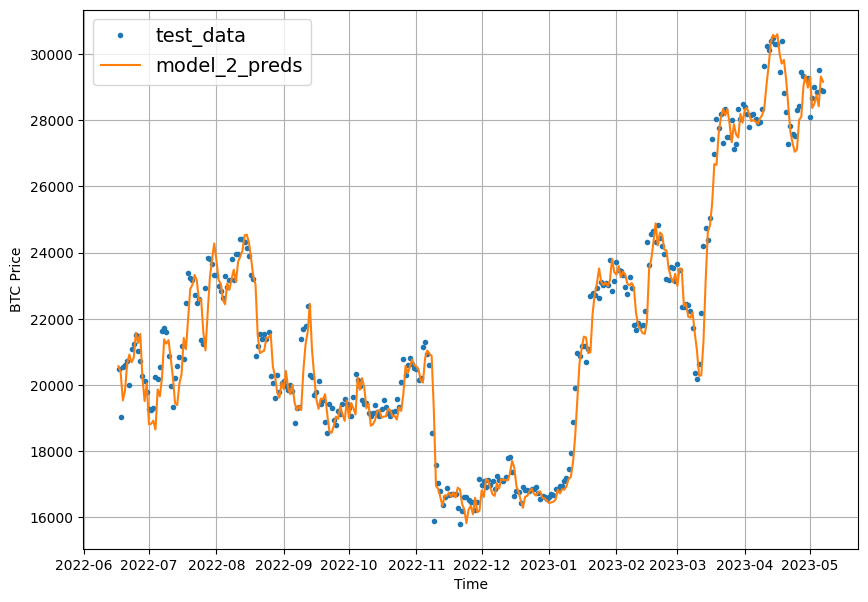

In [61]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [62]:
# Update global variables
HORIZON = 7
WINDOW_SIZE = 30

In [63]:
# Create new windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3119, 3119)

In [64]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2495, 624, 2495, 624)

In [65]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile the model
model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1: val_loss improved from inf to 4129.26025, saving model to model_experiments/model_3_dense



Epoch 2: val_loss improved from 4129.26025 to 2374.34912, saving model to model_experiments/model_3_dense



Epoch 3: val_loss improved from 2374.34912 to 2215.93188, saving model to model_experiments/model_3_dense



Epoch 4: val_loss did not improve from 2215.93188

Epoch 5: val_loss improved from 2215.93188 to 2197.71826, saving model to model_experiments/model_3_dense



Epoch 6: val_loss improved from 2197.71826 to 1877.82947, saving model to model_experiments/model_3_dense



Epoch 7: val_loss did not improve from 1877.82947

Epoch 8: val_loss did not improve from 1877.82947

Epoch 9: val_loss improved from 1877.82947 to 1868.83655, saving model to model_experiments/model_3_dense



Epoch 10: val_loss did not improve from 1868.83655

Epoch 11: val_loss improved from 1868.83655 to 1805.62463, saving model to model_experiments/model_3_dense



Epoch 12: val_loss did not improve from 1805.62463

Epoch 13: val_loss did not improve from 1805.62463

Epoch 14: val_loss did not improve from 1805.62463

Epoch 15: val_loss improved from 1805.62463 to 1789.05444, saving model to model_experiments/model_3_dense



Epoch 16: val_loss did not improve from 1789.05444

Epoch 17: val_loss improved from 1789.05444 to 1736.89941, saving model to model_experiments/model_3_dense



Epoch 18: val_loss did not improve from 1736.89941

Epoch 19: val_loss did not improve from 1736.89941

Epoch 20: val_loss did not improve from 1736.89941

Epoch 21: val_loss did not improve from 1736.89941

Epoch 22: val_loss did not improve from 1736.89941

Epoch 23: val_loss did not improve from 1736.89941

Epoch 24: val_loss did not improve from 1736.89941

Epoch 25: val_loss did not improve from 1736.89941

Epoch 26: val_loss did not improve from 1736.89941

Epoch 27: val_loss did not improve from 1736.89941

Epoch 28: val_loss did not improve from 1736.89941

Epoch 29: val_loss did not improve from 1736.89941

Epoch 30: val_loss improved from 1736.89941 to 1713.02539, saving model to model_experiments/model_3_dense



Epoch 31: val_loss did not improve from 1713.02539

Epoch 32: val_loss did not improve from 1713.02539

Epoch 33: val_loss did not improve from 1713.02539

Epoch 34: val_loss did not improve from 1713.02539

Epoch 35: val_loss did not improve from 1713.02539

Epoch 36: val_loss did not improve from 1713.02539

Epoch 37: val_loss did not improve from 1713.02539

Epoch 38: val_loss did not improve from 1713.02539

Epoch 39: val_loss did not improve from 1713.02539

Epoch 40: val_loss did not improve from 1713.02539

Epoch 41: val_loss did not improve from 1713.02539

Epoch 42: val_loss improved from 1713.02539 to 1703.29932, saving model to model_experiments/model_3_dense



Epoch 43: val_loss did not improve from 1703.29932

Epoch 44: val_loss improved from 1703.29932 to 1662.98706, saving model to model_experiments/model_3_dense



Epoch 45: val_loss did not improve from 1662.98706

Epoch 46: val_loss did not improve from 1662.98706

Epoch 47: val_loss did not improve from 1662.98706

Epoch 48: val_loss did not improve from 1662.98706

Epoch 49: val_loss improved from 1662.98706 to 1648.04321, saving model to model_experiments/model_3_dense



Epoch 50: val_loss did not improve from 1648.04321

Epoch 51: val_loss did not improve from 1648.04321

Epoch 52: val_loss did not improve from 1648.04321

Epoch 53: val_loss did not improve from 1648.04321

Epoch 54: val_loss did not improve from 1648.04321

Epoch 55: val_loss did not improve from 1648.04321

Epoch 56: val_loss did not improve from 1648.04321

Epoch 57: val_loss did not improve from 1648.04321

Epoch 58: val_loss did not improve from 1648.04321

Epoch 59: val_loss did not improve from 1648.04321

Epoch 60: val_loss did not improve from 1648.04321

Epoch 61: val_loss did not improve from 1648.04321

Epoch 62: val_loss did not improve from 1648.04321

Epoch 63: val_loss did not improve from 1648.04321

Epoch 64: val_loss did not improve from 1648.04321

Epoch 65: val_loss did not improve from 1648.04321

Epoch 66: val_loss did not improve from 1648.04321

Epoch 67: val_loss did not improve from 1648.04321

Epoch 68: val_loss did not improve from 1648.04321

Epoch 69: v


Epoch 76: val_loss did not improve from 1641.75781

Epoch 77: val_loss did not improve from 1641.75781

Epoch 78: val_loss did not improve from 1641.75781

Epoch 79: val_loss did not improve from 1641.75781

Epoch 80: val_loss did not improve from 1641.75781

Epoch 81: val_loss did not improve from 1641.75781

Epoch 82: val_loss did not improve from 1641.75781

Epoch 83: val_loss improved from 1641.75781 to 1606.81836, saving model to model_experiments/model_3_dense



Epoch 84: val_loss did not improve from 1606.81836

Epoch 85: val_loss did not improve from 1606.81836

Epoch 86: val_loss did not improve from 1606.81836

Epoch 87: val_loss did not improve from 1606.81836

Epoch 88: val_loss did not improve from 1606.81836

Epoch 89: val_loss did not improve from 1606.81836

Epoch 90: val_loss did not improve from 1606.81836

Epoch 91: val_loss did not improve from 1606.81836

Epoch 92: val_loss did not improve from 1606.81836

Epoch 93: val_loss did not improve from 1606.81836

Epoch 94: val_loss did not improve from 1606.81836

Epoch 95: val_loss did not improve from 1606.81836

Epoch 96: val_loss did not improve from 1606.81836

Epoch 97: val_loss did not improve from 1606.81836

Epoch 98: val_loss did not improve from 1606.81836

Epoch 99: val_loss did not improve from 1606.81836

Epoch 100: val_loss did not improve from 1606.81836


In [66]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1751.9225 - mae: 1751.9225 - mse: 6275010.5000


[1751.9224853515625, 1751.9224853515625, 6275010.5]

In [67]:
# Evaluate the best epoch
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1606.8184 - mae: 1606.8184 - mse: 5648852.0000


[1606.818359375, 1606.818359375, 5648852.0]

In [68]:
# Make the predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47406.09 , 47711.23 , 46764.883, 46816.22 , 46769.336, 47709.438,
        46946.406],
       [46847.63 , 47041.86 , 45699.086, 45856.77 , 46167.242, 47602.45 ,
        46558.125],
       [45429.215, 45549.844, 45076.07 , 44525.613, 44830.688, 45995.832,
        45448.016],
       [45492.062, 45883.477, 45081.6  , 45236.023, 45837.445, 46386.418,
        46010.03 ],
       [46354.637, 46845.617, 46287.914, 46814.277, 46830.32 , 47302.85 ,
        47274.176]], dtype=float32)>

In [69]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([1802.9933  , 2334.188   , 2962.5898  , 2938.5564  , 1953.6736  ,
        1273.3611  , 1864.9877  , 2713.76    , 2775.611   , 1397.2288  ,
        1325.653   , 1140.4905  ,  865.37335 , 1099.0814  , 1221.9994  ,
        1802.6417  , 2532.1567  , 2092.6042  , 2399.9426  , 3151.7935  ,
        3799.763   , 5737.638   , 7675.453   , 2822.319   ,  921.70703 ,
        1213.6814  , 1709.3555  , 2259.062   , 1944.8236  , 2026.0195  ,
        2099.1714  , 2933.8633  , 2701.399   , 3528.5413  , 4133.793   ,
        4769.0073  , 1688.3884  , 2173.2668  , 1125.2701  , 1563.8342  ,
        1413.668   , 2470.053   , 3283.702   , 4000.6418  , 5854.0186  ,
        8069.887   , 7680.5728  , 4233.737   , 4770.9307  , 5550.3516  ,
        5664.6274  , 4722.4297  , 1646.8639  , 1611.4928  , 2389.4753  ,
        2706.4067  , 3019.698   , 2683.8354  , 3964.3137  , 5024.8335  ,
        4973.82    , 1038.8125  , 1436.087   , 1490.5397  , 1467.0011  ,
        2868.4058  , 4764.449   , 1866.8616 

In [70]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([624, 7]), TensorShape([625]))

### Make our `evaluate_preds()` function to work on multiple dimension input data

In [71]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Account for different sized metrics (longer horizons; we want a single value per metric)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [72]:
# Redo model_3_results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1606.8184,
 'mse': 5648852.0,
 'rmse': 1844.0631,
 'mape': 4.829905,
 'mase': 2.094249}

In [73]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47406.09 , 47711.23 , 46764.883, 46816.22 , 46769.336, 47709.438,
        46946.406],
       [46847.63 , 47041.86 , 45699.086, 45856.77 , 46167.242, 47602.45 ,
        46558.125],
       [45429.215, 45549.844, 45076.07 , 44525.613, 44830.688, 45995.832,
        45448.016],
       [45492.062, 45883.477, 45081.6  , 45236.023, 45837.445, 46386.418,
        46010.03 ],
       [46354.637, 46845.617, 46287.914, 46814.277, 46830.32 , 47302.85 ,
        47274.176]], dtype=float32)>

In [74]:
tf.reduce_mean(model_3_preds).shape

TensorShape([])

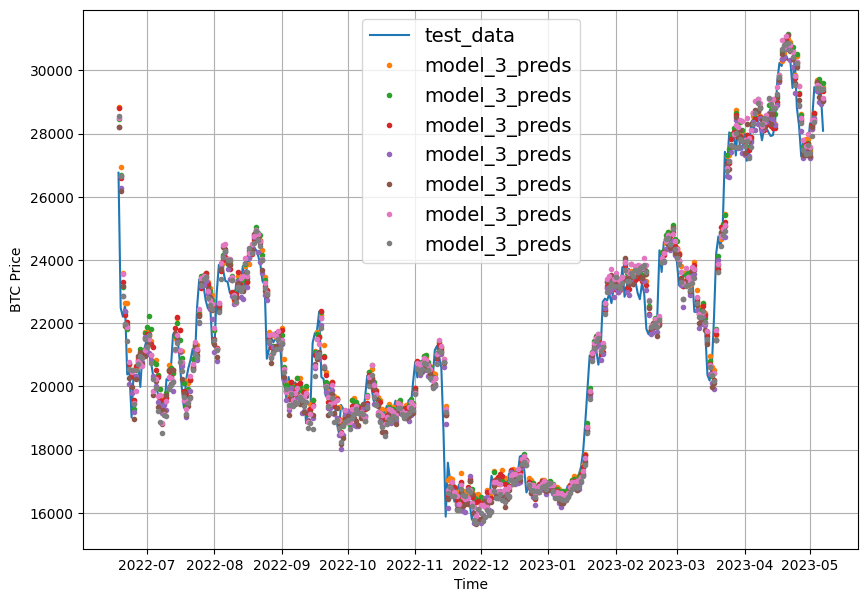

In [75]:
# Plot the model_3_preds
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 start=offset,
                 label='model_3_preds')

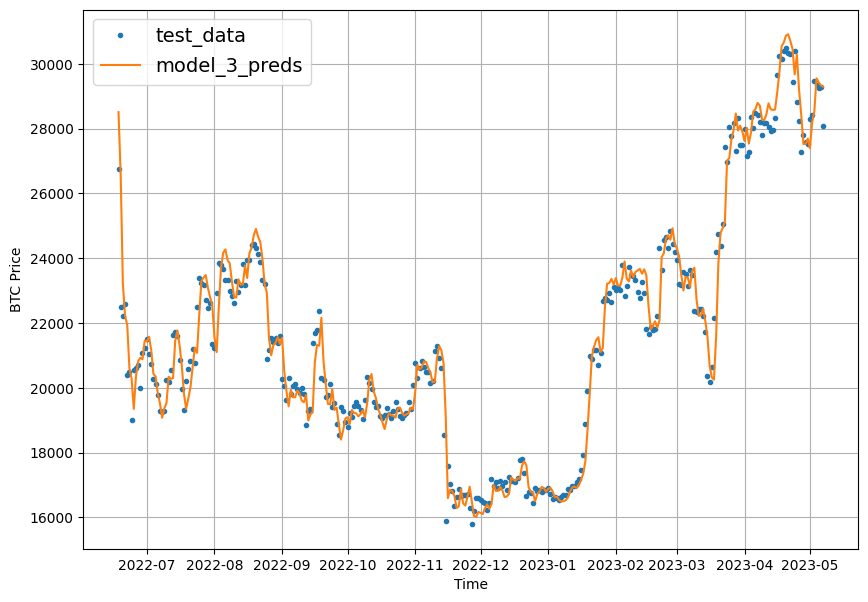

In [76]:
# Plot the model_3_preds - AGGREGATED VERSION 
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label='model_3_preds')

## Which of our models performs the best so far?

<Axes: >

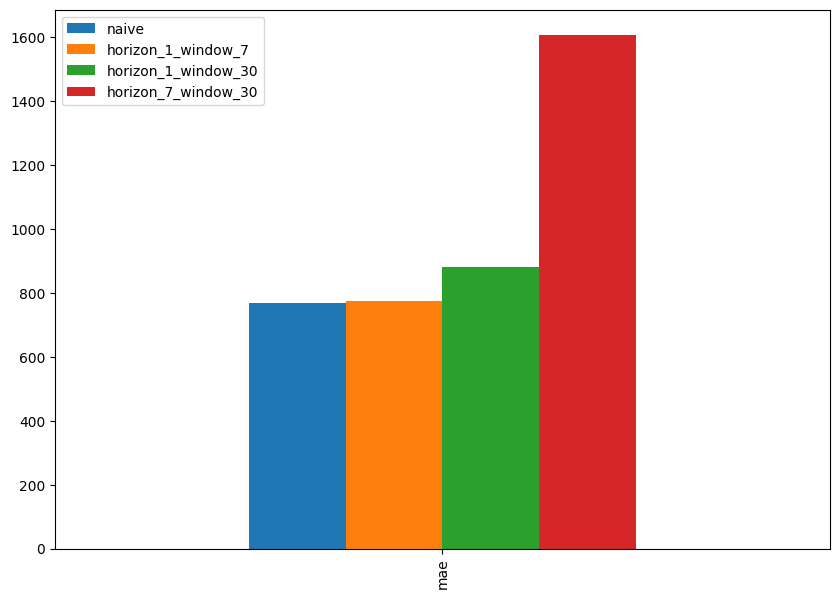

In [77]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot(figsize=(10,7), kind='bar')

## Model 4: Conv1D

In [78]:
HORIZON = 1 # predict next day...
WINDOW_SIZE = 7 # ...based on the week before

In [79]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3148, 3148)

In [80]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                               full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

To use a Conv1D input layer, we need an input shape of `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet.

In [81]:
# Check data input shape
train_windows[0].shape

(7,)

In [82]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [83]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input_dim

In [84]:
# Test out the Lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # WINDOWS_SIZE, INPUT_DIM
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [85]:
# Create the Conv1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128,
                  kernel_size=5,
                  strides=1,
                  padding='causal',
                  activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile a model
model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1: val_loss improved from inf to 5838.78857, saving model to model_experiments/model_4_conv1D



Epoch 2: val_loss improved from 5838.78857 to 1369.61646, saving model to model_experiments/model_4_conv1D



Epoch 3: val_loss did not improve from 1369.61646

Epoch 4: val_loss did not improve from 1369.61646

Epoch 5: val_loss did not improve from 1369.61646

Epoch 6: val_loss did not improve from 1369.61646

Epoch 7: val_loss improved from 1369.61646 to 1313.22168, saving model to model_experiments/model_4_conv1D



Epoch 8: val_loss did not improve from 1313.22168

Epoch 9: val_loss did not improve from 1313.22168

Epoch 10: val_loss improved from 1313.22168 to 1280.92969, saving model to model_experiments/model_4_conv1D



Epoch 11: val_loss improved from 1280.92969 to 1254.27771, saving model to model_experiments/model_4_conv1D



Epoch 12: val_loss did not improve from 1254.27771

Epoch 13: val_loss improved from 1254.27771 to 1253.49487, saving model to model_experiments/model_4_conv1D



Epoch 14: val_loss did not improve from 1253.49487

Epoch 15: val_loss improved from 1253.49487 to 1205.85840, saving model to model_experiments/model_4_conv1D



Epoch 16: val_loss improved from 1205.85840 to 1187.96265, saving model to model_experiments/model_4_conv1D



Epoch 17: val_loss did not improve from 1187.96265

Epoch 18: val_loss did not improve from 1187.96265

Epoch 19: val_loss improved from 1187.96265 to 1147.66064, saving model to model_experiments/model_4_conv1D



Epoch 20: val_loss did not improve from 1147.66064

Epoch 21: val_loss did not improve from 1147.66064

Epoch 22: val_loss improved from 1147.66064 to 1147.01050, saving model to model_experiments/model_4_conv1D



Epoch 23: val_loss improved from 1147.01050 to 1092.85242, saving model to model_experiments/model_4_conv1D



Epoch 24: val_loss did not improve from 1092.85242

Epoch 25: val_loss improved from 1092.85242 to 1043.22266, saving model to model_experiments/model_4_conv1D



Epoch 26: val_loss improved from 1043.22266 to 1027.79529, saving model to model_experiments/model_4_conv1D



Epoch 27: val_loss improved from 1027.79529 to 999.39185, saving model to model_experiments/model_4_conv1D



Epoch 28: val_loss did not improve from 999.39185

Epoch 29: val_loss did not improve from 999.39185

Epoch 30: val_loss improved from 999.39185 to 954.94287, saving model to model_experiments/model_4_conv1D



Epoch 31: val_loss improved from 954.94287 to 945.10474, saving model to model_experiments/model_4_conv1D



Epoch 32: val_loss did not improve from 945.10474

Epoch 33: val_loss did not improve from 945.10474

Epoch 34: val_loss improved from 945.10474 to 924.36151, saving model to model_experiments/model_4_conv1D



Epoch 35: val_loss did not improve from 924.36151

Epoch 36: val_loss did not improve from 924.36151

Epoch 37: val_loss did not improve from 924.36151

Epoch 38: val_loss improved from 924.36151 to 913.04041, saving model to model_experiments/model_4_conv1D



Epoch 39: val_loss did not improve from 913.04041

Epoch 40: val_loss improved from 913.04041 to 881.04492, saving model to model_experiments/model_4_conv1D



Epoch 41: val_loss improved from 881.04492 to 877.62927, saving model to model_experiments/model_4_conv1D



Epoch 42: val_loss did not improve from 877.62927

Epoch 43: val_loss did not improve from 877.62927

Epoch 44: val_loss did not improve from 877.62927

Epoch 45: val_loss did not improve from 877.62927

Epoch 46: val_loss did not improve from 877.62927

Epoch 47: val_loss did not improve from 877.62927

Epoch 48: val_loss did not improve from 877.62927

Epoch 49: val_loss did not improve from 877.62927

Epoch 50: val_loss improved from 877.62927 to 857.18842, saving model to model_experiments/model_4_conv1D



Epoch 51: val_loss did not improve from 857.18842

Epoch 52: val_loss improved from 857.18842 to 854.27869, saving model to model_experiments/model_4_conv1D



Epoch 53: val_loss did not improve from 854.27869

Epoch 54: val_loss did not improve from 854.27869

Epoch 55: val_loss did not improve from 854.27869

Epoch 56: val_loss did not improve from 854.27869

Epoch 57: val_loss did not improve from 854.27869

Epoch 58: val_loss did not improve from 854.27869

Epoch 59: val_loss did not improve from 854.27869

Epoch 60: val_loss improved from 854.27869 to 839.13861, saving model to model_experiments/model_4_conv1D



Epoch 61: val_loss did not improve from 839.13861

Epoch 62: val_loss did not improve from 839.13861

Epoch 63: val_loss did not improve from 839.13861

Epoch 64: val_loss did not improve from 839.13861

Epoch 65: val_loss did not improve from 839.13861

Epoch 66: val_loss did not improve from 839.13861

Epoch 67: val_loss improved from 839.13861 to 829.57391, saving model to model_experiments/model_4_conv1D



Epoch 68: val_loss did not improve from 829.57391

Epoch 69: val_loss did not improve from 829.57391

Epoch 70: val_loss did not improve from 829.57391

Epoch 71: val_loss improved from 829.57391 to 820.96918, saving model to model_experiments/model_4_conv1D



Epoch 72: val_loss did not improve from 820.96918

Epoch 73: val_loss did not improve from 820.96918

Epoch 74: val_loss did not improve from 820.96918

Epoch 75: val_loss improved from 820.96918 to 815.79950, saving model to model_experiments/model_4_conv1D



Epoch 76: val_loss did not improve from 815.79950

Epoch 77: val_loss did not improve from 815.79950

Epoch 78: val_loss did not improve from 815.79950

Epoch 79: val_loss did not improve from 815.79950

Epoch 80: val_loss did not improve from 815.79950

Epoch 81: val_loss did not improve from 815.79950

Epoch 82: val_loss did not improve from 815.79950

Epoch 83: val_loss did not improve from 815.79950

Epoch 84: val_loss did not improve from 815.79950

Epoch 85: val_loss did not improve from 815.79950

Epoch 86: val_loss improved from 815.79950 to 804.74115, saving model to model_experiments/model_4_conv1D



Epoch 87: val_loss did not improve from 804.74115

Epoch 88: val_loss improved from 804.74115 to 804.37805, saving model to model_experiments/model_4_conv1D



Epoch 89: val_loss did not improve from 804.37805

Epoch 90: val_loss improved from 804.37805 to 802.41901, saving model to model_experiments/model_4_conv1D



Epoch 91: val_loss did not improve from 802.41901

Epoch 92: val_loss did not improve from 802.41901

Epoch 93: val_loss did not improve from 802.41901

Epoch 94: val_loss did not improve from 802.41901

Epoch 95: val_loss did not improve from 802.41901

Epoch 96: val_loss did not improve from 802.41901

Epoch 97: val_loss improved from 802.41901 to 801.99121, saving model to model_experiments/model_4_conv1D



Epoch 98: val_loss did not improve from 801.99121

Epoch 99: val_loss did not improve from 801.99121

Epoch 100: val_loss did not improve from 801.99121


In [86]:
# Evaluate model_4
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 882.5454 - mae: 882.5454 - mse: 1703252.8750


[882.54541015625, 882.54541015625, 1703252.875]

In [87]:
# Load in the best performing model_4
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 801.9912 - mae: 801.9912 - mse: 1513869.1250


[801.9912109375, 801.9912109375, 1513869.125]

In [88]:
# Make predictions 
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47396.66 , 46487.168, 45157.832, 44753.16 , 46199.7  , 48807.617,
       49364.17 , 49715.02 , 49859.15 , 48408.12 ], dtype=float32)>

In [89]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 801.9912,
 'mse': 1513869.2,
 'rmse': 1230.3939,
 'mape': 2.3690987,
 'mase': 1.0450827}

In [90]:
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

## Model 5: LSTM
Let's create a RNN model for our time series data.

We're going to use the same data we have created for previous experiment.

In [91]:
# Let's create LSTM model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer='adam')
                #metrics=['mae', 'mse'])

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 6055.6099
Epoch 1: val_loss improved from inf to 14403.65234, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 5s 117ms/step - loss: 6017.6011 - val_loss: 14403.6523
Epoch 2/100
11/20 [===============>..............] - ETA: 0s - loss: 2525.3416
Epoch 2: val_loss improved from 14403.65234 to 2699.68896, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 110ms/step - loss: 1677.1625 - val_loss: 2699.6890
Epoch 3/100
12/20 [=================>............] - ETA: 0s - loss: 629.7775
Epoch 3: val_loss improved from 2699.68896 to 1347.79370, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 90ms/step - loss: 562.5441 - val_loss: 1347.7937
Epoch 4/100
12/20 [=================>............] - ETA: 0s - loss: 411.4897
Epoch 4: val_loss improved from 1347.79370 to 1234.54736, saving model to model_experiments/

In [92]:
# Load in the best version of model_5 and evaluate
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 830.1561


830.1561279296875

In [93]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

20/20 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47325.387, 46406.848, 45432.94 , 44820.62 , 45953.49 ],
      dtype=float32)>

In [94]:
# Evaluate model_5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 830.1561,
 'mse': 1584241.1,
 'rmse': 1258.6664,
 'mape': 2.453874,
 'mase': 1.0817846}

In [95]:
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

## Make a multivariate time series data

Before we add feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...
* day 1 - 0
* day 2 - 1
* day 3 - 0 and so on

What's a better feature to use?

Maybe Bitcon halving events?

In [96]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [97]:
# Let's add Bitcoin halving events to our data
block_reward_1 = 50 # 3 Jan 2009 - this reward isn't in our dataset (start from 17/9/2014)
block_reward_2 = 25 # 28 Nov 2012 - this reward isn't in our dataset, too
block_reward_3 = 12.5 # 9 Jul 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [98]:
# Create date ranges where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2070)

In [99]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframes
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-05-03,29006.308594,6.25
2023-05-04,28847.710938,6.25
2023-05-05,29534.384766,6.25
2023-05-06,28904.623047,6.25
2023-05-07,28897.636719,6.25


<Axes: xlabel='Date'>

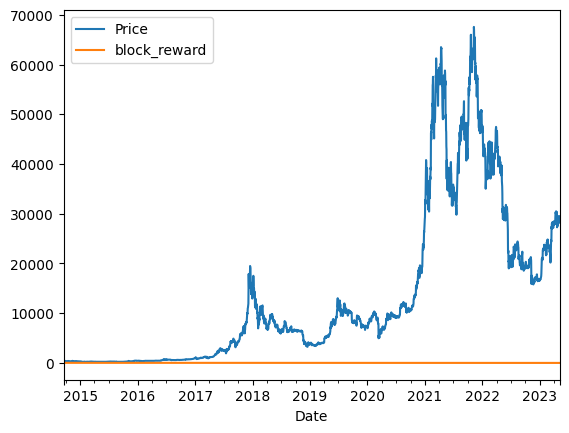

In [100]:
bitcoin_prices_block.plot()

<Axes: xlabel='Date'>

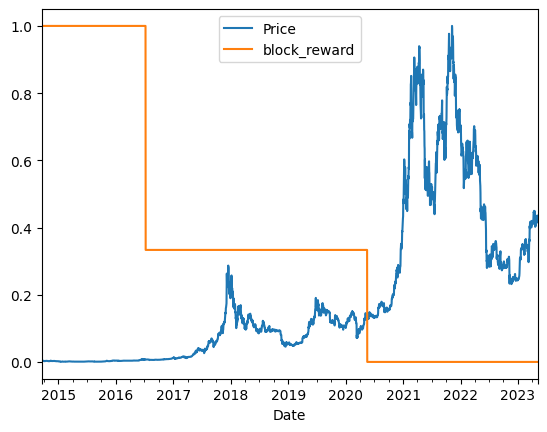

In [101]:
# Plot the block_reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot()

## Making a windowed dataset with `Pandas`
Previously we've turned our univariate time series into windowed dataset using helper functions above.

However, since we'ge got multivariate now, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data. 

In [102]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [103]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


What we've done is create a way to window our dataset directly from a `pandas.DataFrame`.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
...
```

In [104]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
 2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
 2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
 2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
 2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2014-09-24  394.795990  424.440002  457.334015  
 2014-09-25  408.903992  394.795990  424.440002  
 2014-09-26  398.821014  408.903992  394.795990  
 2014-09-27  402.152008  398.821014  408.903992  
 2014-09-28  435.790985  402.152008  398.821014  ,
 Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.51998

In [105]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [106]:
X_train

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-08-11,6.25,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688,39747.503906
2021-08-12,6.25,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688
2021-08-13,6.25,44428.289062,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000


## Model 6: Dense (but on multivariate data)

In [107]:
tf.random.set_seed(42)

# Make a multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile the model
model_6.compile(loss='mae',
                optimizer='adam')

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
15/20 [=====================>........] - ETA: 0s - loss: 2440.4260 
Epoch 1: val_loss improved from inf to 1752.17102, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 2s 40ms/step - loss: 2035.8140 - val_loss: 1752.1710
Epoch 2/100
16/20 [=======================>......] - ETA: 0s - loss: 501.3221
Epoch 2: val_loss improved from 1752.17102 to 1112.59827, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 474.4240 - val_loss: 1112.5983
Epoch 3/100
15/20 [=====================>........] - ETA: 0s - loss: 362.8027
Epoch 3: val_loss improved from 1112.59827 to 1108.75269, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 55ms/step - loss: 351.0332 - val_loss: 1108.7527
Epoch 4/100
16/20 [=======================>......] - ETA: 0s - loss: 316.8458
Epoch 4: val_loss improved from 1108.75269 to 966.04810, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 327.3840 - val_loss: 966.0481
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 325.8653
Epoch 5: val_loss improved from 966.04810 to 867.66211, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 325.8653 - val_loss: 867.6621
Epoch 6/100
18/20 [==========================>...] - ETA: 0s - loss: 292.3073
Epoch 6: val_loss did not improve from 867.66211
20/20 [==============================] - 0s 5ms/step - loss: 300.9425 - val_loss: 896.3865
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 317.5127
Epoch 7: val_loss did not improve from 867.66211
20/20 [==============================] - 0s 5ms/step - loss: 317.5127 - val_loss: 982.8764
Epoch 8/100
20/20 [==============================] - ETA: 0s - loss: 302.3246
Epoch 8: val_loss improved from 867.66211 to 850.13068, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 302.3246 - val_loss: 850.1307
Epoch 9/100
17/20 [========================>.....] - ETA: 0s - loss: 317.6046
Epoch 9: val_loss did not improve from 850.13068
20/20 [==============================] - 0s 5ms/step - loss: 313.5932 - val_loss: 974.2592
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 321.5828
Epoch 10: val_loss did not improve from 850.13068
20/20 [==============================] - 0s 5ms/step - loss: 285.7923 - val_loss: 872.7681
Epoch 11/100
 1/20 [>.............................] - ETA: 0s - loss: 246.9269
Epoch 11: val_loss improved from 850.13068 to 846.89923, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 289.5418 - val_loss: 846.8992
Epoch 12/100
17/20 [========================>.....] - ETA: 0s - loss: 285.8548
Epoch 12: val_loss improved from 846.89923 to 825.35205, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 284.4930 - val_loss: 825.3521
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 224.1945
Epoch 13: val_loss did not improve from 825.35205
20/20 [==============================] - 0s 4ms/step - loss: 280.2840 - val_loss: 828.6788
Epoch 14/100
 1/20 [>.............................] - ETA: 0s - loss: 230.3233
Epoch 14: val_loss did not improve from 825.35205
20/20 [==============================] - 0s 4ms/step - loss: 282.7992 - val_loss: 986.7520
Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 329.0852
Epoch 15: val_loss did not improve from 825.35205
20/20 [==============================] - 0s 5ms/step - loss: 329.0852 - val_loss: 919.9055
Epoch 16/100
 1/20 [>.............................] - ETA: 0s - loss: 334.9278
Epoch 16: val_loss improved from 825.35205 to 818.59790, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 291.2362 - val_loss: 818.5979
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 277.1693
Epoch 17: val_loss improved from 818.59790 to 810.56317, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 277.1693 - val_loss: 810.5632
Epoch 18/100
20/20 [==============================] - ETA: 0s - loss: 272.1490
Epoch 18: val_loss improved from 810.56317 to 807.13519, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 36ms/step - loss: 272.1490 - val_loss: 807.1352
Epoch 19/100
14/20 [====================>.........] - ETA: 0s - loss: 266.5944
Epoch 19: val_loss did not improve from 807.13519
20/20 [==============================] - 0s 7ms/step - loss: 273.4194 - val_loss: 1061.4415
Epoch 20/100
15/20 [=====================>........] - ETA: 0s - loss: 334.9218
Epoch 20: val_loss did not improve from 807.13519
20/20 [==============================] - 0s 7ms/step - loss: 343.3694 - val_loss: 1212.9432
Epoch 21/100
13/20 [==================>...........] - ETA: 0s - loss: 377.1175
Epoch 21: val_loss did not improve from 807.13519
20/20 [==============================] - 0s 7ms/step - loss: 335.7613 - val_loss: 812.9579
Epoch 22/100
15/20 [=====================>........] - ETA: 0s - loss: 270.9451
Epoch 22: val_loss did not improve from 807.13519
20/20 [==============================] - 0s 7ms/step - loss: 275.9384 - val_loss: 836.5093
Epoch 23/100
15/20 [======

20/20 [==============================] - 1s 54ms/step - loss: 276.4807 - val_loss: 803.6506
Epoch 26/100
12/20 [=================>............] - ETA: 0s - loss: 258.8437
Epoch 26: val_loss did not improve from 803.65057
20/20 [==============================] - 0s 9ms/step - loss: 271.1176 - val_loss: 814.0573
Epoch 27/100
13/20 [==================>...........] - ETA: 0s - loss: 260.2447
Epoch 27: val_loss did not improve from 803.65057
20/20 [==============================] - 0s 9ms/step - loss: 274.0924 - val_loss: 856.2138
Epoch 28/100
12/20 [=================>............] - ETA: 0s - loss: 294.6140
Epoch 28: val_loss did not improve from 803.65057
20/20 [==============================] - 0s 9ms/step - loss: 265.9121 - val_loss: 810.4708
Epoch 29/100
12/20 [=================>............] - ETA: 0s - loss: 267.7364
Epoch 29: val_loss did not improve from 803.65057
20/20 [==============================] - 0s 9ms/step - loss: 265.3476 - val_loss: 824.8805
Epoch 30/100
11/20 [========

20/20 [==============================] - 1s 51ms/step - loss: 274.4193 - val_loss: 798.6426
Epoch 31/100
10/20 [==============>...............] - ETA: 0s - loss: 286.7508
Epoch 31: val_loss did not improve from 798.64258
20/20 [==============================] - 0s 9ms/step - loss: 272.1524 - val_loss: 806.0818
Epoch 32/100
11/20 [===============>..............] - ETA: 0s - loss: 276.6100
Epoch 32: val_loss improved from 798.64258 to 792.27136, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 52ms/step - loss: 284.0726 - val_loss: 792.2714
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 285.0892
Epoch 33: val_loss did not improve from 792.27136
20/20 [==============================] - 0s 10ms/step - loss: 285.0892 - val_loss: 952.0266
Epoch 34/100
12/20 [=================>............] - ETA: 0s - loss: 308.5442
Epoch 34: val_loss did not improve from 792.27136
20/20 [==============================] - 0s 8ms/step - loss: 296.3542 - val_loss: 988.3199
Epoch 35/100
14/20 [====================>.........] - ETA: 0s - loss: 269.7760
Epoch 35: val_loss did not improve from 792.27136
20/20 [==============================] - 0s 6ms/step - loss: 274.6845 - val_loss: 845.8225
Epoch 36/100
16/20 [=======================>......] - ETA: 0s - loss: 259.1230
Epoch 36: val_loss did not improve from 792.27136
20/20 [==============================] - 0s 7ms/step - loss: 268.8322 - val_loss: 829.5411
Epoch 37/100
15/20 [=======

20/20 [==============================] - 1s 44ms/step - loss: 280.4432 - val_loss: 789.4000
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 279.4525
Epoch 39: val_loss did not improve from 789.39996
20/20 [==============================] - 0s 4ms/step - loss: 279.4525 - val_loss: 825.1896
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 295.1823
Epoch 40: val_loss improved from 789.39996 to 785.61591, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 295.1823 - val_loss: 785.6159
Epoch 41/100
19/20 [===========================>..] - ETA: 0s - loss: 273.4378
Epoch 41: val_loss did not improve from 785.61591
20/20 [==============================] - 0s 5ms/step - loss: 270.1687 - val_loss: 788.6312
Epoch 42/100
 1/20 [>.............................] - ETA: 0s - loss: 230.3913
Epoch 42: val_loss did not improve from 785.61591
20/20 [==============================] - 0s 5ms/step - loss: 262.7010 - val_loss: 788.7453
Epoch 43/100
20/20 [==============================] - ETA: 0s - loss: 263.9435
Epoch 43: val_loss did not improve from 785.61591
20/20 [==============================] - 0s 4ms/step - loss: 263.9435 - val_loss: 794.1439
Epoch 44/100
 1/20 [>.............................] - ETA: 0s - loss: 295.9983
Epoch 44: val_loss did not improve from 785.61591
20/20 [==============================] - 0s 5ms/step - loss: 266.0547 - val_loss: 919.3807
Epoch 45/100
20/20 [========

20/20 [==============================] - 1s 53ms/step - loss: 265.0644 - val_loss: 779.6885
Epoch 58/100
20/20 [==============================] - ETA: 0s - loss: 277.8252
Epoch 58: val_loss did not improve from 779.68848
20/20 [==============================] - 0s 5ms/step - loss: 277.8252 - val_loss: 852.9644
Epoch 59/100
 1/20 [>.............................] - ETA: 0s - loss: 223.9013
Epoch 59: val_loss did not improve from 779.68848
20/20 [==============================] - 0s 4ms/step - loss: 272.6983 - val_loss: 847.5322
Epoch 60/100
19/20 [===========================>..] - ETA: 0s - loss: 275.0013
Epoch 60: val_loss did not improve from 779.68848
20/20 [==============================] - 0s 5ms/step - loss: 272.4661 - val_loss: 886.4537
Epoch 61/100
 1/20 [>.............................] - ETA: 0s - loss: 317.9067
Epoch 61: val_loss did not improve from 779.68848
20/20 [==============================] - 0s 4ms/step - loss: 295.8652 - val_loss: 867.4964
Epoch 62/100
 1/20 [>.......

20/20 [==============================] - 1s 33ms/step - loss: 293.5382 - val_loss: 778.8923
Epoch 78/100
 1/20 [>.............................] - ETA: 0s - loss: 224.8961
Epoch 78: val_loss did not improve from 778.89233
20/20 [==============================] - 0s 4ms/step - loss: 265.3987 - val_loss: 863.0512
Epoch 79/100
20/20 [==============================] - ETA: 0s - loss: 272.1960
Epoch 79: val_loss did not improve from 778.89233
20/20 [==============================] - 0s 5ms/step - loss: 272.1960 - val_loss: 1419.2058
Epoch 80/100
15/20 [=====================>........] - ETA: 0s - loss: 333.6401
Epoch 80: val_loss did not improve from 778.89233
20/20 [==============================] - 0s 5ms/step - loss: 324.7184 - val_loss: 968.9048
Epoch 81/100
 1/20 [>.............................] - ETA: 0s - loss: 387.9186
Epoch 81: val_loss improved from 778.89233 to 775.80939, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 285.7400 - val_loss: 775.8094
Epoch 82/100
 1/20 [>.............................] - ETA: 0s - loss: 174.4247
Epoch 82: val_loss did not improve from 775.80939
20/20 [==============================] - 0s 5ms/step - loss: 292.8924 - val_loss: 779.1705
Epoch 83/100
20/20 [==============================] - ETA: 0s - loss: 269.7428
Epoch 83: val_loss did not improve from 775.80939
20/20 [==============================] - 0s 4ms/step - loss: 269.7428 - val_loss: 780.3536
Epoch 84/100
20/20 [==============================] - ETA: 0s - loss: 279.4444
Epoch 84: val_loss did not improve from 775.80939
20/20 [==============================] - 0s 4ms/step - loss: 279.4444 - val_loss: 917.5408
Epoch 85/100
17/20 [========================>.....] - ETA: 0s - loss: 276.1719
Epoch 85: val_loss did not improve from 775.80939
20/20 [==============================] - 0s 6ms/step - loss: 273.8945 - val_loss: 795.6684
Epoch 86/100
19/20 [========

In [108]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 3ms/step - loss: 792.1925


792.1925048828125

In [109]:
# Load best performing model
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 3ms/step - loss: 775.8092


775.8092041015625

In [110]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47046.953, 46270.125, 44649.934, 44740.656, 46393.402, 49047.453,
       49112.336, 49420.008, 49664.77 , 47887.668], dtype=float32)>

In [111]:
# Evaluate predictions to get metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 775.8092,
 'mse': 1420043.1,
 'rmse': 1191.6556,
 'mape': 2.284528,
 'mase': 1.0109646}

In [112]:
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

In [113]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

## Model 7: N-BEATS algorithm
Let's now try andbuild the biggest, baddest time series forecasting model we've built so far.

More specifically, we'll be replicating the algo from the paper's figure 1:
https://arxiv.org/pdf/1905.10437.pdf

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow subclassing to make our own custom layers
* We will get experiance using the Functional API to create custom architecture
* Potintially get state-of-the-art results and beat the Naive forecast 

### Building and testing the N-BEATS block layer

Because N-BEATS block layer does not exist in TensorFlow, we need to create it.

To create custom layers and models, we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [114]:
# Create N-BEATS block custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__ (self, 
                input_size: int,
                theta_size: int,
                horizon: int,
                n_neurons: int,
                n_layers: int,
                **kwargs): # the keyword args argument takces care of all the parent args (input_size etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 FC layers, each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # 'call' function is obligatory when inhereting from Layer class
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output - backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

LEt's test our N-BEATS block class. To do so, we'll make some dummy inputs and outputs.

In [115]:
# Setup dummy N-BEATS block layer to represent inputs and outputs
tf.random.set_seed(42)

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast and forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [116]:
# Create dummy inputs (have to be the same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE + 1), axis=0) # input shape has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [117]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are going to be activation outputs of the theta layer (random due to no training)
print(f"Backcast: \n{tf.squeeze(backcast).numpy()},\n\nForecast:\n {tf.squeeze(forecast).numpy()}")

Backcast: 
[-0.25476542 -0.5728767   1.0196568  -0.3217531   0.02578022 -0.78040123
  0.07712017],

Forecast:
 -0.08052609860897064


### Preparing data for N-BEATS algorithm using `tf.data` API

To make our input data load as fast as possible, we're going to be adhearing to the performant data pipeline steps in the tf.data guide.

In [118]:
WINDOW_SIZE = 7
HORIZON = 1

In [119]:
# Create NBEATS data inputs (N-BEATS with univariate time series)
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


In [120]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [121]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make test/train sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [122]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm
The N-BEATS has a few fair number of parameters, many of them can be found in the Table 18 of the paper mentioned earlier.

In [123]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for the residual connections
Before we can craft our N-BEATS model, we need two layers for the residual connectsions - substract and add.

N-BEATS uses double residual stacking to help train its deeper architecture (section 3.2 in paper). 

In [124]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract
subtracted = layers.Subtract()([tensor_1, tensor_2])

# Add
added = layers.Add()([tensor_1, tensor_2])

# Results
subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of `NBeatsBlock()` subclass layer (this'll be the initial block used for the network, the rest will be created as a part of stacks).
2. Create an input layer for the N-BEATS stack (we'll be using the `Keras Functional API`. 
3. Make the initial backcast and forecast for the model with the layer created in (1).
4. Use `for()` loop to create stack of block layers.
5. Use `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using `layers.subtract` and `layers.add`.
7. Put the model inputs and outputs together using `tf.keras.Model`.
8. Compile the model with MAE loss function (to keep it in line with previous experiments) and `Adam` optimizer with default settings as per section 5.2 of the paper.
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so long, we'll use a couple of callbacks:
  * `EarlyStopping` - because the model will fit so long, we'll stop it early if it stops improving
  * `ReduceLRonPlateau` - if a model stops improving, try lowering the learning rate to reduce the amount it improves on its weights each time (take smaller steps towards best performance)

In [125]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack already created in 3.

  # 5. Use the N-BEATS block to calculate backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put together inputs and outputs of our stack
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_7_nbeats')

# 8. Compile model with MAE loss
model_7.compile(loss='mae',
                optimizer='adam')

# 9. Fit the model with EarlyStopping on ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])

Epoch 1/5000
3/3 [==============================] - 54s 1s/step - loss: 2337.3157 - val_loss: 967828.1250 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 166ms/step - loss: 40311.6953 - val_loss: 13976.0156 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 64ms/step - loss: 3081.6606 - val_loss: 88386.7656 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 62ms/step - loss: 26601.6504 - val_loss: 20929.9785 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 64ms/step - loss: 7157.7944 - val_loss: 28784.0801 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 62ms/step - loss: 7636.8008 - val_loss: 27466.8633 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 64ms/step - loss: 6749.8682 - val_loss: 23923.6582 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 133ms/step - loss: 5259.6782 - val_loss: 10810.2568 - lr: 0.0010
Epoch 9/5000
3/3 [==========================

In [126]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 26ms/step - loss: 778.4336


778.43359375

In [127]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47191.15 , 46025.01 , 44561.44 , 44727.098, 46471.145, 49256.066,
       49161.855, 49439.81 , 49514.414, 47824.312], dtype=float32)>

In [128]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 778.4336,
 'mse': 1420124.4,
 'rmse': 1191.6897,
 'mape': 2.285089,
 'mase': 1.0143845}

In [129]:
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

In [130]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

### Plotting the N-BEATS architecture we've created

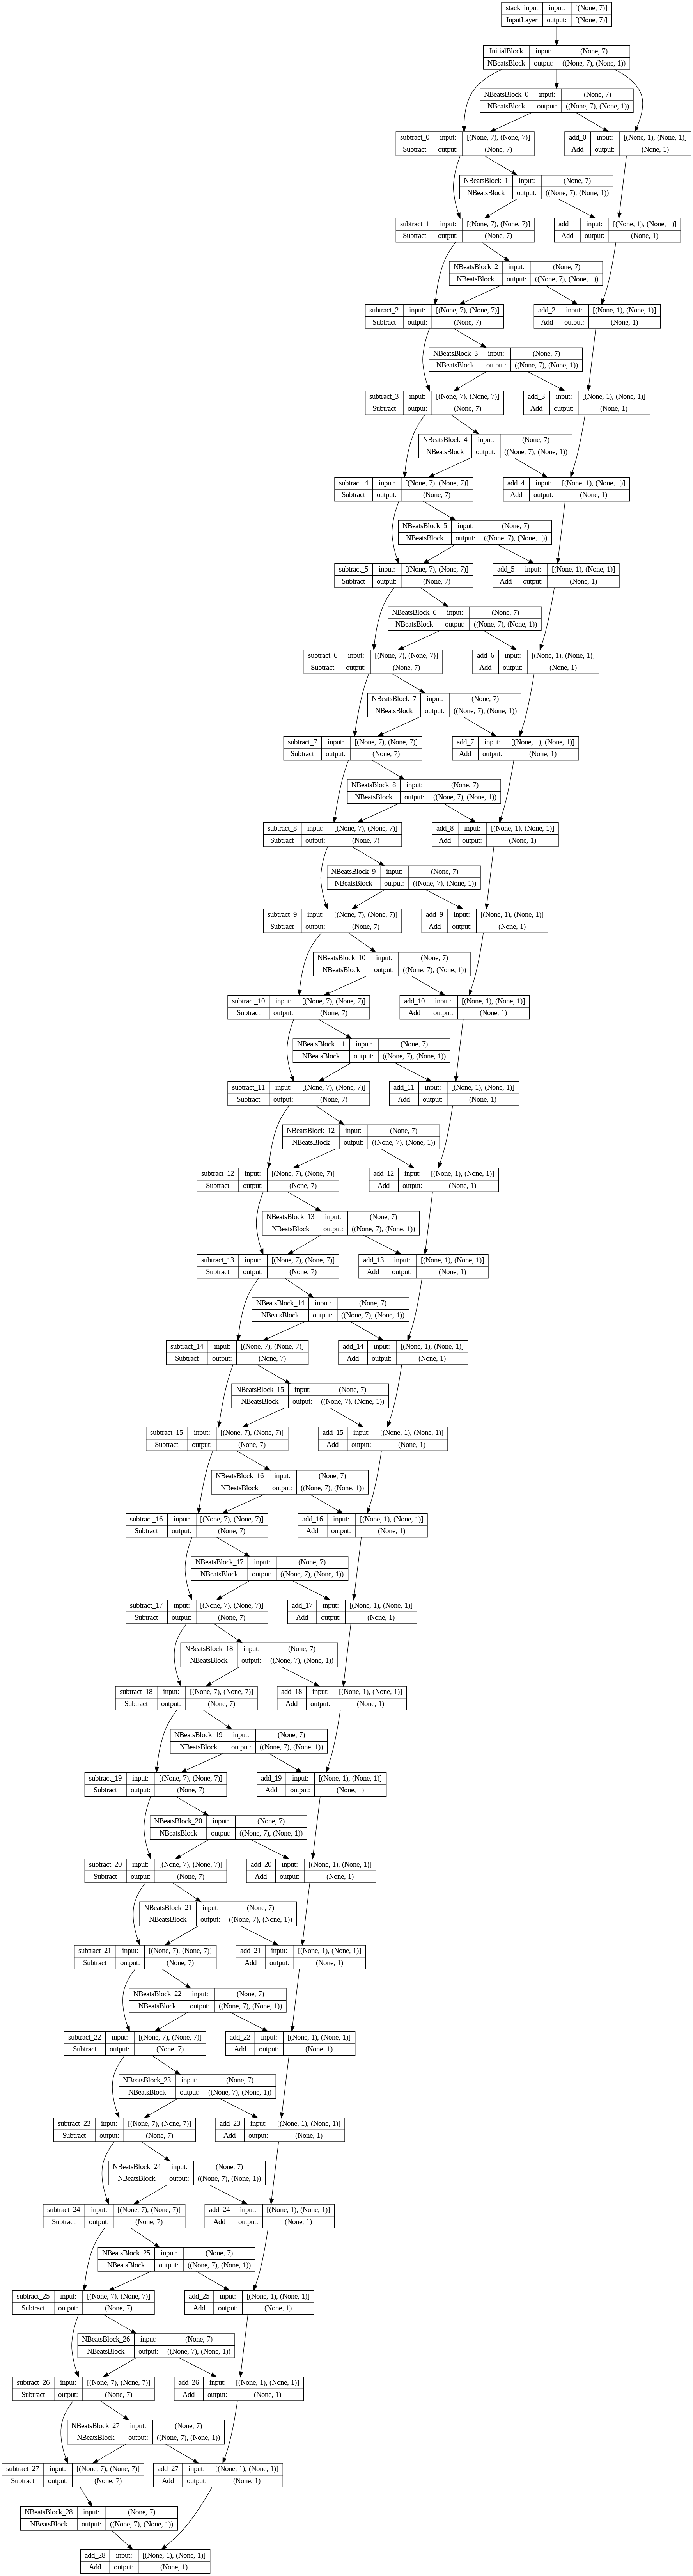

In [131]:
# Plot the N-BEATS model
tf.keras.utils.plot_model(model_7,
                          show_shapes=True,
                          show_layer_activations=True)

## Model 8: Creating an ensemble (Stacking different models together)
As ensemble leverages *the wisdom of the crowd* effect. It combines many **different** models to predict a common goal.

In [132]:
# A small reminder
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (use different loss functions)

In [133]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=['mae', 'mse', 'mape']):
  """
  Returns a list of num_iter models each trained on MAE, MSE, MAPE loss metrics.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(loss_fn)
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize Dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'), # kernal initializer tells what kind of patterns should the optimizer start with
          layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
          layers.Dense(HORIZON)
      ], name=f"model_{i}_{loss_function}")

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)
  
  return ensemble_models

In [134]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing mae for 1000 epochs, model number: 0

Epoch 993: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 epochs, model number: 0

Epoch 612: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 712: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs, model number: 0

Epoch 198: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 317: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 421: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 521: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by reducing mae for 1000 epochs, model number: 1
Optimizing model by reducing mse for 1000 epochs, model number: 1

Epoch 530: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 630: ReduceLROnPlateau

In [135]:
# Check the length
len(ensemble_models)

15

### Make predictions with our ensemble models

In [136]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  
  return tf.constant(tf.squeeze(ensemble_preds))

In [137]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step
CPU times: user 705 ms, sys: 24.8 ms, total: 729 ms
Wall time: 838 ms


<tf.Tensor: shape=(15, 630), dtype=float32, numpy=
array([[46950.863, 46000.426, 44385.195, ..., 28758.633, 29518.621,
        28920.863],
       [47025.39 , 46217.72 , 44450.305, ..., 28772.357, 29550.744,
        28884.527],
       [47079.95 , 46256.777, 44474.637, ..., 28790.049, 29590.09 ,
        28898.975],
       ...,
       [47236.035, 46280.023, 44633.918, ..., 28905.775, 29710.6  ,
        29092.209],
       [46781.918, 46246.53 , 44675.863, ..., 28632.852, 29573.98 ,
        28856.092],
       [46986.152, 45835.69 , 44781.6  , ..., 28877.148, 29438.492,
        28940.254]], dtype=float32)>

In [138]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 796.91077,
 'mse': 1471574.6,
 'rmse': 1212.1174,
 'mape': 2.3462753,
 'mase': 1.0384623}

In [139]:
# Check for different possibilities of combining ensemble predictions
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_median = np.median(ensemble_preds, axis=0)

In [140]:
# Ensemble results for both metrics
ensemble_results_mean = evaluate_preds(y_test, ensemble_mean)
ensemble_results_median = evaluate_preds(y_test, ensemble_median)
ensemble_results_median, ensemble_results_mean

({'mae': 771.2262,
  'mse': 1406293.5,
  'rmse': 1185.8724,
  'mape': 2.2663078,
  'mase': 1.0049925},
 {'mae': 775.33093,
  'mse': 1419633.1,
  'rmse': 1191.4835,
  'mape': 2.2759104,
  'mase': 1.0103414})

### Plotting the prediction intervals (uncertainty estimates) of our ensemble
So far we've been making point predictions with our models. 

E.g. horizon = 1, our model predicts tomorrow price of BTC will be $50.000 USD. 

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of $50.000 USD on the dot, how about 48.000-52.000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the boostrap method:
1. Take the predictions from a number of randomly initialized models (we do have that from our ensemble models).
2. Measure the standard deviation of the predictions.
3. Multiply the standard deviation by 1.96 (assuming the distribution of our data is Gaussian/Normal, 95% of observsations fall within 1.96 standard deviations of the mean).
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1).

Materials:
https://en.wikipedia.org/wiki/97.5th_percentile_point

In [141]:
# Find the upper and lower bands of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predicitons
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [142]:
# Get the upper and lower bounds of 95% prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46689.113, 45642.773, 44045.78 , 44203.047, 46135.97 , 49021.355,
        48723.164, 49110.086, 49187.844, 47234.61 ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47435.605, 46658.72 , 45236.71 , 45396.1  , 46754.03 , 49696.81 ,
        49788.367, 49843.92 , 50142.96 , 48582.85 ], dtype=float32)>)

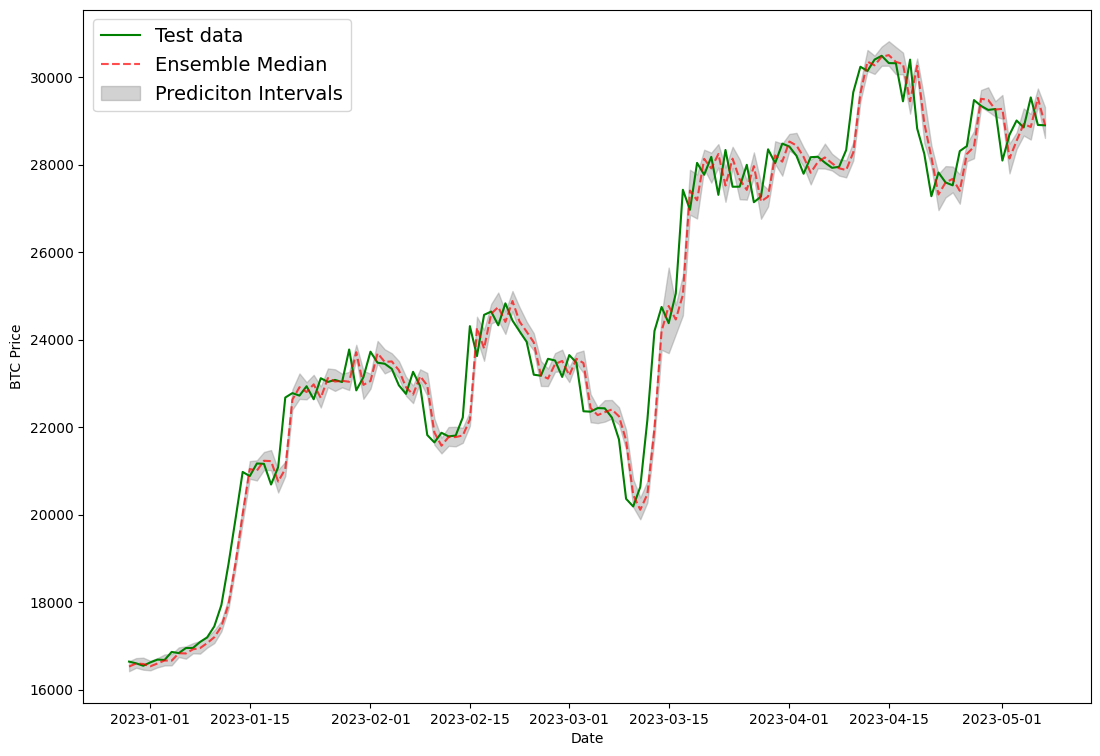

In [143]:
# Get the median/mean values of our ensemble_preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediciton intervals (where the predictions fall between)
offset = 500

plt.figure(figsize=(13,9))

plt.plot(X_test.index[offset:],
         y_test[offset:],
         color='green',
         label='Test data')

plt.plot(X_test.index[offset:],
         ensemble_median[offset:],
         '--',
         color='red',
         alpha=0.7,
         label='Ensemble Median')

plt.xlabel('Date')
plt.ylabel('BTC Price')

# To plot the bounds, lets use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediciton Intervals",
                 color='grey',
                 alpha=0.35)
plt.legend(loc='upper left',
           fontsize=14)

So far all of our models prediction have been lagging behind the test data as if they were replicating what the naive model does and just predict the previous timestep as the nex timestep.

> **NOTE:** These prediction intervals are predicitons themselves and have been created with an assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainity (coconut and subway)

## Model 9: Future prediction model (trained on the full historical data avaliable)

So far all of our models have predicted on the test dataset (so pseudo-future data), however this not enough.

Let's now build a model which is capable of predicting into the future!

In [144]:
HORIZON = 1
WINDOW_SIZE = 7

In [145]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [146]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2023-05-03,29006.308594,6.25,28680.537109,28091.568359,29268.806641,29248.488281,29340.261719,29473.787109,28422.701172
2023-05-04,28847.710938,6.25,29006.308594,28680.537109,28091.568359,29268.806641,29248.488281,29340.261719,29473.787109
2023-05-05,29534.384766,6.25,28847.710938,29006.308594,28680.537109,28091.568359,29268.806641,29248.488281,29340.261719
2023-05-06,28904.623047,6.25,29534.384766,28847.710938,29006.308594,28680.537109,28091.568359,29268.806641,29248.488281
2023-05-07,28897.636719,6.25,28904.623047,29534.384766,28847.710938,29006.308594,28680.537109,28091.568359,29268.806641


In [147]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()
len(X_all), len(y_all)

(3148, 3148)

In [148]:
# Turn data info efficient tensors with tf.data API
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [149]:
tf.random.set_seed(42)

# Create a model
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_9_future_model')

# Compile
model_9.compile(loss='mae',
                optimizer='adam')

# Fit on all of the data
model_9.fit(dataset_all,
            epochs=100,
            verbose=0,
            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('model_experiments', model_9.name),
                                                          monitor='loss',
                                                          save_weights_only=True,
                                                          verbose=0)])

model_9

### Make prediction into the future

In [150]:
# How many timesteps to predict into the future
INTO_FUTURE = 14

To make predictions into the future, we want a function which:
1. Takes as input:
* a list of values (BTC historical data)
* a trained model (such as `model_9`)
* a window into the future to predict (our `INTO_FUTURE` variable)
* the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data (shape) it was trained on

2. Create an empty list for future forecasts (so this will be returned at the end of the function, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values.

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.

In [151]:
# 1. Create function to make prediction into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecast as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on
  for _ in range(INTO_FUTURE):

    # Predict on the last window then append it again, again, again
    # (model will eventually start to predict on it's own forecast)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n{last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds
    # (because our model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [152]:
# Make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 59ms/step
Predicting on: 
[28091.568359 28680.537109 29006.308594 28847.710938 29534.384766
 28904.623047 28897.636719] -> Prediction: 28275.41796875

1/1 [==============================] - 0s 19ms/step
Predicting on: 
[28680.537109   29006.308594   28847.710938   29534.384766
 28904.623047   28897.636719   28275.41796875] -> Prediction: 28727.9453125

1/1 [==============================] - 0s 18ms/step
Predicting on: 
[29006.308594   28847.710938   29534.384766   28904.623047
 28897.636719   28275.41796875 28727.9453125 ] -> Prediction: 28780.00390625

1/1 [==============================] - 0s 18ms/step
Predicting on: 
[28847.710938   29534.384766   28904.623047   28897.636719
 28275.41796875 28727.9453125  28780.00390625] -> Prediction: 28715.513671875

1/1 [==============================] - 0s 20ms/step
Predicting on: 
[29534.384766   28904.623047   28897.636719   28275.41796875
 28727.9453125  28780.00390625 28715.51367188] -> Prediction: 2

### Plot future forecasts

In [153]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Return array of datetime values ranging from start_date to start_date + into_future.
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date

  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [154]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2023-05-07 00:00:00')

In [155]:
# Get two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11',
       '2023-05-12', '2023-05-13', '2023-05-14', '2023-05-15',
       '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19',
       '2023-05-20', '2023-05-21'], dtype='datetime64[D]')

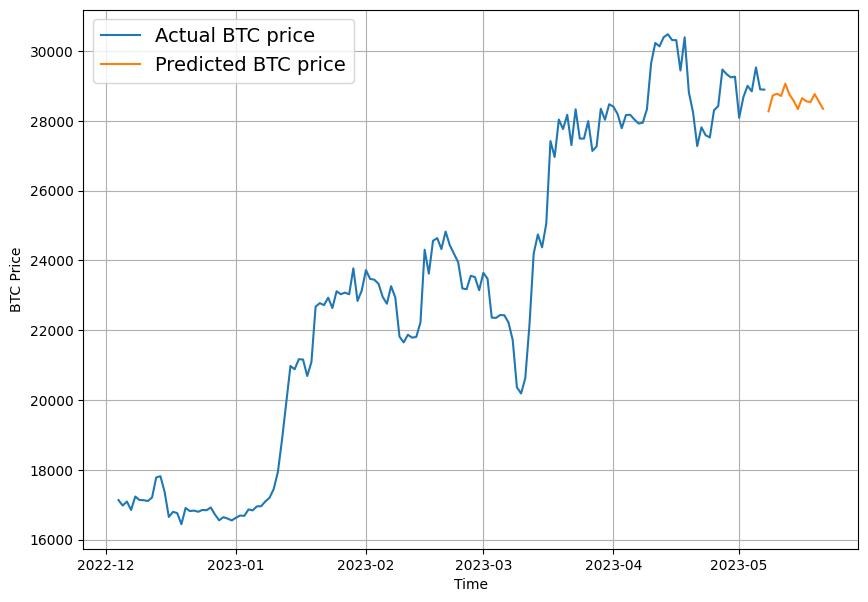

In [156]:
# Plot future price predictions of BTC
plt.figure(figsize=(10,7))

plot_time_series(bitcoin_prices.index,
                 btc_price,
                 start=3000,
                 format='-',
                 label='Actual BTC price')

plot_time_series(next_time_steps,
                 future_forecast,
                 format="-",
                 label="Predicted BTC price")

In [157]:
# Insert last timestep/final price into next timesteps and future forecasts
# so the plot will not be disjointed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10',
        '2023-05-11', '2023-05-12', '2023-05-13', '2023-05-14',
        '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
        '2023-05-19', '2023-05-20', '2023-05-21'], dtype='datetime64[D]'),
 array([28897.637, 28275.418, 28727.945, 28780.004, 28715.514, 29068.246,
        28754.96 , 28577.188, 28339.203, 28652.85 , 28563.697, 28539.324,
        28769.676, 28556.477, 28346.938], dtype=float32))

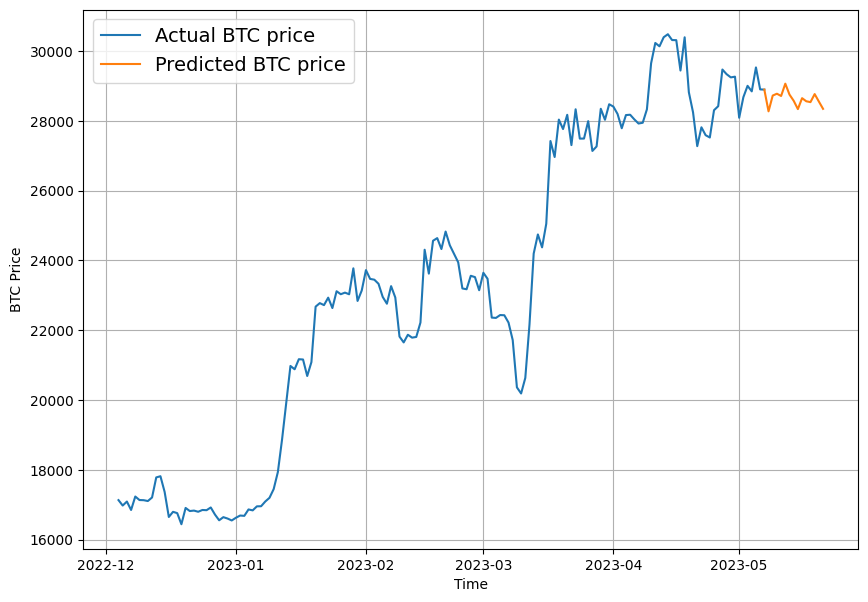

In [158]:
# Plot again to check
plt.figure(figsize=(10,7))

plot_time_series(bitcoin_prices.index,
                 btc_price,
                 start=3000,
                 format='-',
                 label='Actual BTC price')

plot_time_series(next_time_steps,
                 future_forecast,
                 format="-",
                 label="Predicted BTC price")

## Model 10: The turkey problem (so why forecasting is BS)

In [160]:
# Intruducing a turkey data to BTC problem (price falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100 # dividing last data point
btc_price_turkey[-10:]

[29340.261719,
 29248.488281,
 29268.806641,
 28091.568359,
 28680.537109,
 29006.308594,
 28847.710938,
 29534.384766,
 28904.623047,
 288.97636718999996]

In [162]:
# Get the timesteps
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2023-04-28T00:00:00.000000000', '2023-04-29T00:00:00.000000000',
       '2023-04-30T00:00:00.000000000', '2023-05-01T00:00:00.000000000',
       '2023-05-02T00:00:00.000000000', '2023-05-03T00:00:00.000000000',
       '2023-05-04T00:00:00.000000000', '2023-05-05T00:00:00.000000000',
       '2023-05-06T00:00:00.000000000', '2023-05-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

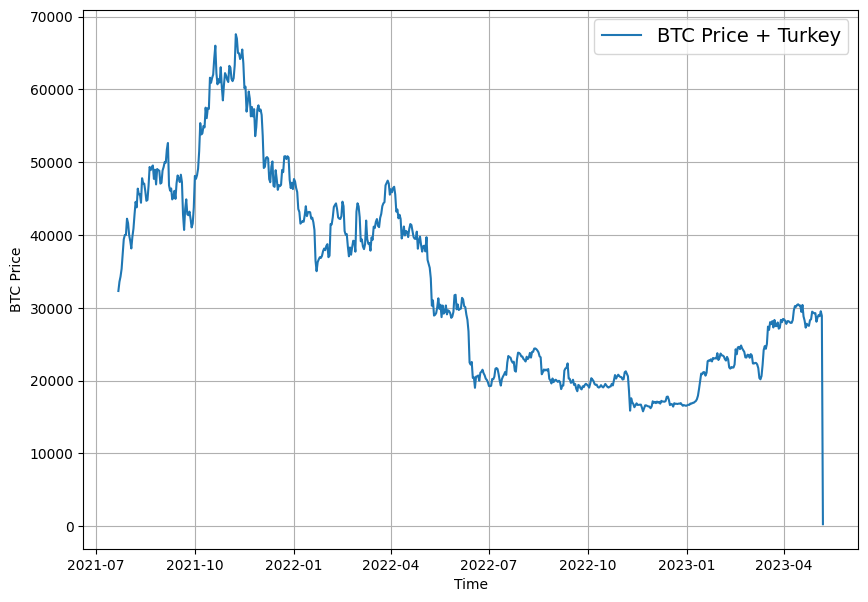

In [164]:
# Plot turkey data
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey",
                 start=2500)

In [165]:
HORIZON = 1
WINDOW_SIZE = 7

In [167]:
# Create train and test sets for turkey problem
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

### Build a turkey model (model to predict on turkey data)

In [175]:
# Clone model_1 architecture
model_10 = tf.keras.models.clone_model(model_1)
model_10._name = "model_10_turkey"
model_10.summary()

Model: "model_10_turkey"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [179]:
# Compile model_10

model_10.compile(loss='mae',
                 optimizer='adam')

# Fit turkey model
model_10.fit(X_train,
             y_train,
             epochs=100,
             verbose=0,
             batch_size=128,
             validation_data=(X_test, y_test),
             callbacks=[create_model_checkpoint(model_10.name)])


Epoch 1: val_loss improved from inf to 974.10950, saving model to model_experiments/model_10_turkey

Epoch 2: val_loss improved from 974.10950 to 835.75684, saving model to model_experiments/model_10_turkey

Epoch 3: val_loss did not improve from 835.75684

Epoch 4: val_loss improved from 835.75684 to 827.01556, saving model to model_experiments/model_10_turkey

Epoch 5: val_loss did not improve from 827.01556

Epoch 6: val_loss did not improve from 827.01556

Epoch 7: val_loss did not improve from 827.01556

Epoch 8: val_loss did not improve from 827.01556

Epoch 9: val_loss did not improve from 827.01556

Epoch 10: val_loss did not improve from 827.01556

Epoch 11: val_loss did not improve from 827.01556

Epoch 12: val_loss did not improve from 827.01556

Epoch 13: val_loss improved from 827.01556 to 824.92041, saving model to model_experiments/model_10_turkey

Epoch 14: val_loss did not improve from 824.92041

Epoch 15: val_loss did not improve from 824.92041

Epoch 16: val_loss di

In [180]:
# Evaluate model_10
model_10.evaluate(X_test, y_test)

20/20 [==============================] - 0s 6ms/step - loss: 825.4727


825.4727172851562

In [181]:
# Load best turkey model and evaluate
model_10 = tf.keras.models.load_model('model_experiments/model_10_turkey')
model_10.evaluate(X_test, y_test)

20/20 [==============================] - 1s 5ms/step - loss: 821.1823


821.1823120117188

In [182]:
# Make predictions 
model_10_preds = make_preds(model_10, X_test)
model_10_preds[:10]

20/20 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([46990.47 , 46192.797, 44590.547, 44791.785, 46448.04 , 49182.97 ,
       49088.94 , 49353.273, 49629.805, 47865.28 ], dtype=float32)>

In [183]:
# Evaluate preds
model_10_results = evaluate_preds(y_true=y_test,
                                  y_pred=model_10_preds)
model_10_results

{'mae': 15296.254,
 'mse': 374994430.0,
 'rmse': 18826.973,
 'mape': 69.7764,
 'mase': 18.81741}

In [184]:
model_1_results

{'mae': 775.3892,
 'mse': 1413156.9,
 'rmse': 1188.7627,
 'mape': 2.2808754,
 'mase': 1.0104173}

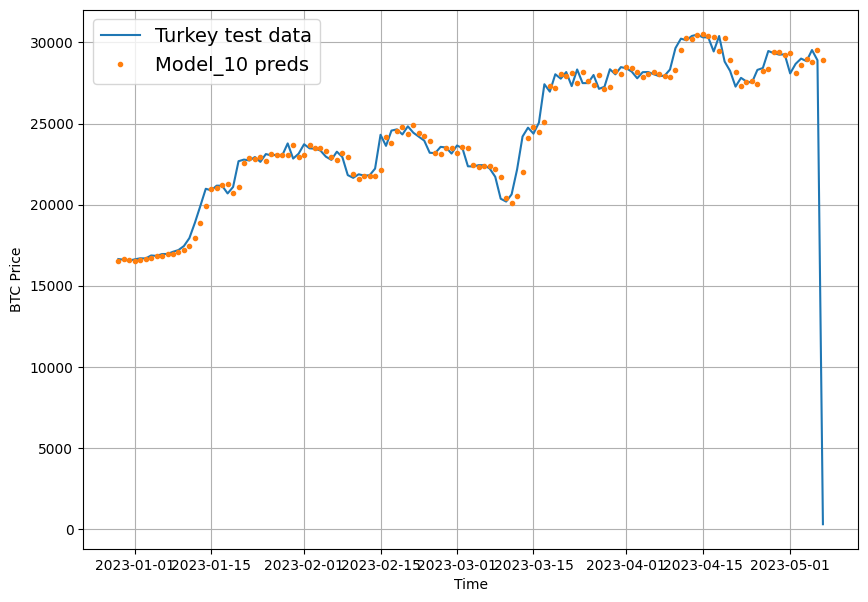

In [197]:
# Plot the results
plt.figure(figsize=(10,7))
offset=500

plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey test data",
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=model_10_preds,
                 label="Model_10 preds",
                 start=offset)

## Compare all models

In [202]:
# Compare different model results(w = window, h = horizon)
model_results = pd.DataFrame({'naive_model': naive_results,
                              'model_1_dense_w7_h1': model_1_results,
                              'model_2_dense_w30_h1': model_2_results,
                              'model_3_dense_w30_h7': model_3_results,
                              'model_4_conv1d': model_4_results,
                              'model_5_lstm': model_5_results,
                              'model_6_multivariate': model_6_results,
                              'model_7_nbeats': model_7_results,
                              'model_8_ensemble': ensemble_results,
                              'model_10_turkey': model_10_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,767.831726,1.377889e+06,1173.834961,2.257612,1.000569
model_1_dense_w7_h1,775.389221,1.413157e+06,1188.762695,2.280875,1.010417
model_2_dense_w30_h1,880.651001,1.684930e+06,1298.048706,2.625605,1.153728
model_3_dense_w30_h7,1606.818359,5.648852e+06,1844.063110,4.829905,2.094249
model_4_conv1d,801.991211,1.513869e+06,1230.393921,2.369099,1.045083
model_5_lstm,830.156128,1.584241e+06,1258.666382,2.453874,1.081785
model_6_multivariate,775.809204,1.420043e+06,1191.655640,2.284528,1.010965
model_7_nbeats,778.433594,1.420124e+06,1191.689697,2.285089,1.014385
model_8_ensemble,796.910767,1.471575e+06,1212.117432,2.346275,1.038462
model_10_turkey,15296.253906,3.749944e+08,18826.972656,69.776398,18.817410


<Axes: >

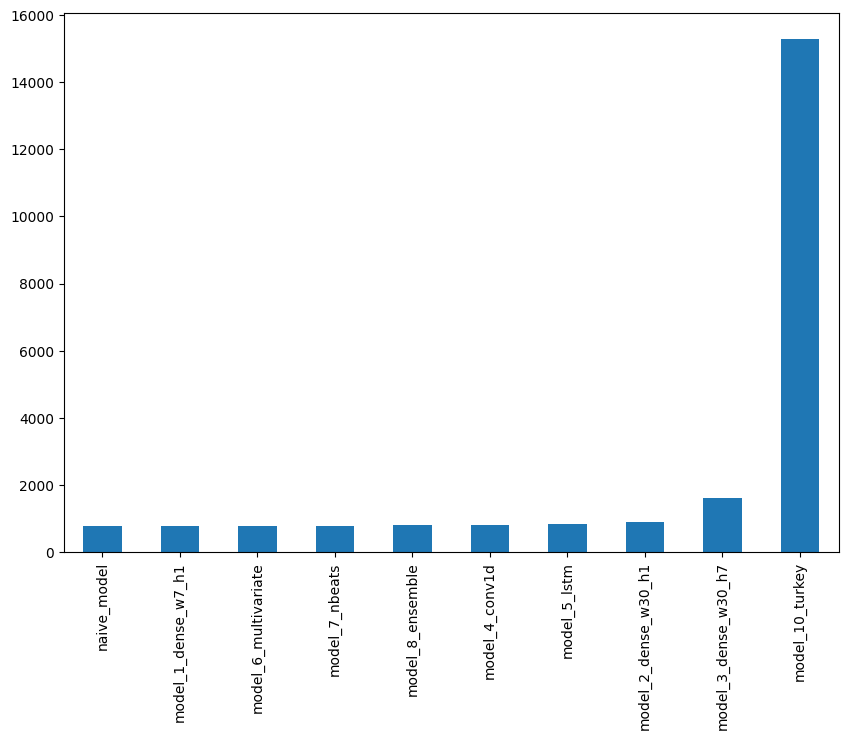

In [203]:
# Sort results by MAE and plot them
model_results['mae'].sort_values().plot(figsize=(10,7), kind='bar')